# Home task intern data scientist, Aramco Inn.
This home task is for an intern data scientist. The task is to build a multioutput regression model. Link to the data: https://disk.yandex.com/d/-n1_UXqKXJw1_g

Target variables are ['bv_0', ..., 'bv_100', 'pc_0', ..., 'pc_100']
it is basically 2d data (pc_* - x axis, bv_* - y axis) this is mercury injection capillary pressure (MICP) experiment data:


1.	Create baseline model of your choice. This should be a simple model (e. g. naive prediction) that can be used to compare the performance of more complex models

2.	Create a multioutput regression model to predict multiple outputs from a given dataset. This could be a linear regression model, a neural network, or any other suitable model

3.	Use appropriate techniques to preprocess the data, such as normalization, feature selection, and feature engineering

4.	Evaluate the performance of the model using appropriate metrics and cross-validation strategy. Use test data to come up with the strategy. Compare it to the baseline

5.	Tune the model's hyperparameters to optimize the model's performance (if needed)

6.	Visualize the results of the model predictions to provide insights into the data

7.	Suggest the improvements to the model. This should include any insights gained from the model and any recommendations for further improvements

8.	Provide a brief summary of the model and the results at the end of the Jupyter notebook (1 paragraph of text in English).

9.	Send the notebook to @voskresenskiianton. Keep size of the notebook <5 mb


The dataset contains measurements and features related to core samples taken from different wells. The features include:

* group - identifier of the well from which the core sample was taken 

* sample - identifier of the core sample; all the data related to a particular well are recorded in one shot 

* depth - depth at which the core sample was taken 

* por - measured porosity of the core sample; porosity is the fraction of the volume of pores (empty spaces) to the total volume of the rock 

* permeability - measured permeability of the core plug sample; permeability is a measure of the ability of a rock to allow fluids to pass through it 

* den - measured density of the core plug sample; density is the mass per unit volume of the rock 

* thickness_effective - effective (net) thickness of a formation from which the sample was taken 

* ntg - net-to-gross ratio of a formation from which the sample was taken; NTG is the ratio of the thickness of reservoir rock to the thickness of the entire interval sampled 

* x, y - well coordinates 

* lithology - lithology of core plug sample, determined by a geologist; lithology refers to the physical and chemical characteristics of a rock, such as its mineral composition, texture, and color 

* gr - measured gamma ray log of the sample depth; gamma ray log measures naturally occurring radioactivity of a formation, which is mainly used for determination of the shaliness of a formation. The values of gamma ray log will be low in clay-free rocks such as sandstones, limestones, dolostones, anhydrites, most salts, and coals, but high in shales because of high concentrations of radioactive material 

* rhob measured density log of the sample depth; density log is related to the bulk density of formation. It is used for determination of porosity and lithology differentiation. Measured density values will be closer to the mineralogical (matrix) density in formation with low porosity, and with an increase in porosity, density values will get lower 

* ct_* - Data related to computer tomographic measurements

In [1]:
import pandas as pd 
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from striplog import Striplog
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
%matplotlib inline

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import mutual_info_regression as mir
# from sklearn.neighbors import KNeighborsRegressor 

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge, ElasticNet
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.utils import resample, shuffle
from sklearn.svm import SVR
from xgboost import XGBRegressor as xgb
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge

In [5]:
from fitter import Fitter, get_common_distributions, get_distributions
from easydev import Progress

In [6]:
from scipy.stats import shapiro, anderson, normaltest

In [7]:
import re

In [8]:
# import optuna as optuna

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
def colind(dset, collist):  # Columnn names to column indexes
    return [dset.columns.get_loc(i) for i in collist]

In [11]:
def Outlier_hunter(feature, method, IQR_cf=[1.5, 1.5], Sigma_cf=[3, 3], verbose=2):
    outliers_dict=dict()
    # outliers_list=[]
    stat=feature.T.describe()
    rstat=stat[['mean', 'std', '25%', '50%', '75%']]
    vrange=list(stat[['min', 'max']].round(2))
    if method=='IQR':
        IQR=rstat[4]-rstat[2]
        LL=round(rstat[2]-IQR_cf[0]*IQR, 2)
        RL=round(rstat[4]+IQR_cf[1]*IQR, 2)
        limits=[LL, RL]
        outliers=feature[~feature.between(*limits)]
        opct_iqr=round((len(outliers)/feature.shape[0]), 4)
        if verbose>=2:
            print('* IQR method with IQR coeff. values: {} is {} which amounts {} %'.format(IQR_cf, len(outliers), round(opct_iqr*100),3))    
    elif method=='Sigma':
        LS=rstat[0]-Sigma_cf[0]*rstat[1]        
        RS=rstat[0]+Sigma_cf[1]*rstat[1]   
        limits=[LS, RS]
        outliers=feature[~feature.between(*limits)]
        opct_z=round((len(outliers)/feature.shape[0]), 4) 
        if verbose>=2:
            print('* Z-score method with sigma coeff. values: {} is {} which amounts {} %'.format(Sigma_cf, len(outliers), round(opct_z*100),3))           
    if verbose>=1:
        if feature.min()<min(limits) or feature.max()>max(limits): 
            plt.figure(figsize=[7, 0.15])
            sns.boxplot(x=feature, orient='h').set(xlabel=feature.name)
            plt.axvline(x = limits[0],  color ='red')
            plt.axvline(x = limits[1],  color ='red')
            plt.show()         
            # print(82*'_','\n')
    if len(outliers.index)>0:
        return list(outliers.index)
    else:
        print(f'No outliers was found! \n Acceptable values range by {method}: {limits} \n Observed values range: {vrange} \n')
        # if verbose>=2:
        #     plt.figure(figsize=[6.4, 1])
        #     sns.histplot(feature)
        # else:
        #     pass
        # print(82*'_','\n')
        return
    # return feature.agg(['min', 'max'])

In [12]:
def distexaminer_lit(feature, method, IQR_cf=[1.5, 1.5], Sigma_cf=[3, 3], Nbest=3, verbose=2):
    ollist=[]
    for lit in data_train.lithology.unique():
        print("\033[2m" + lit.upper().center(79, '*') +"\033[0;0m")
        if verbose>=2:
            plt.figure(figsize=[6.5, 1.75])
            f=Fitter(data_train[data_train.lithology==lit][feature].T, bins=45) 
            f.distributions=['norm', 'gamma', 'logistic', 'lognorm', 'expon', 'exponnorm', 'uniform']
            f.fit()      
            display(f.summary(Nbest=Nbest).round(3).drop('kl_div', axis=1))
            plt.show() 
        ol=Outlier_hunter(data_train[data_train.lithology==lit][feature], method=method, IQR_cf=IQR_cf, verbose=verbose)
        if ol is None:
            continue
        else:
            print(f'Outliers: {ol} \n')
            plt.show()
            ollist.extend(ol)     
    print(f'Total number of outliers: {len(ollist)}')
    return [*ollist]

In [13]:
def distexaminer(feature, method="IQR", IQR_cf=[1.5, 1.5], Sigma_cf=[3, 3], Nbest=3, verbose=2):
    ollist=[]
    print("\033[2m" + feature.name.upper().center(79, '*') +"\033[0;0m")
    plt.figure(figsize=[6.5, 1.75])
    f=Fitter(feature.T, bins=45) 
    f.distributions=['norm', 'gamma', 'logistic', 'lognorm', 'expon', 'exponnorm', 'uniform']
    f.fit()      
    display(f.summary(Nbest=Nbest).round(3).drop('kl_div', axis=1))
    plt.show() 
    ol=Outlier_hunter(feature, method=method, IQR_cf=IQR_cf, Sigma_cf=Sigma_cf, verbose=verbose)
    plt.show()
    if ol is None:
        return
    else:
        return ol

In [14]:
def Normality_checker(feature, methods):
    test_dict=dict()
    for i in [*methods]:        
        if i=='shapiro':
            test_dict['shapiro']=shapiro(feature)[1]
        if i=='normaltest':
            test_dict['normaltest']=normaltest(feature)[1] 
    return test_dict          
            

In [15]:
def outdropper(df, outlist):
    return df.drop([*outlist])

In [16]:
cm = sns.light_palette("lightblue", as_cmap=True)

## 1) Data loading and data validity check

For the begging we are loading data and making validity check.

In [17]:
data_train=pd.read_csv('train.csv')
display(data_train.head(5), data_train.shape)

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
0,3,52,1660.178974,18.556209,2.740942,1971.579998,2396.714551,2799.219912,1951.977330,2041.857394,...,20517.973164,23072.031367,25918.199746,29130.680234,32741.818105,36776.940391,41337.948828,46440.194570,52182.348633,58608.434023
1,4,92,3890.779426,8.555400,2.834776,2513.180531,3001.782975,2348.160682,2414.636280,2798.706138,...,4178.079326,4564.280930,4987.905991,5457.903966,5976.209199,6537.572468,7149.014724,7826.130471,8559.884813,9368.567796
2,3,90,2287.441253,-0.169935,2.761468,2274.773580,1083.899155,2974.647775,2713.863889,2381.094609,...,20522.705605,23075.290605,25927.208926,29136.474492,32743.575156,36780.525273,41344.256875,46461.810508,52207.803164,58651.855859
3,3,49,2144.788740,28.192998,2.637605,1776.270868,2374.721334,2670.367528,2814.751969,2919.311685,...,20522.544570,23075.227422,25928.721426,29137.418496,32742.759414,36779.554531,41344.410508,46463.711484,52212.429531,58661.142344
4,2,65,3754.453151,4.136069,2.900202,1787.771840,1893.016733,2818.411074,1542.522104,2246.952313,...,4223.781546,4615.144614,5045.280631,5520.831567,6044.115860,6611.085441,7231.857753,7913.697529,8657.308785,9475.725759


(455, 222)

In [18]:
data_train.shape

(455, 222)

In [19]:
data_test=pd.read_csv('test.csv')
data_test.head(5)

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,permeability,ntg,thickness_effective,x,y,lithology,gr,rhob
0,6,0,2541.519832,17.574182,2.721184,2397.858599,2530.129882,2419.635540,2410.149830,2378.142534,2245.973152,2419.142862,9.686923,0.642302,8.331449,19250,4113,limestone,38.502328,2.709270
1,6,1,2492.499349,15.601646,2.731073,2493.479588,2381.180205,2374.025753,2122.706339,2535.031736,1926.894657,2213.529371,25.113567,0.202864,6.434557,19250,4113,clay sandstone,41.279069,2.629994
2,6,2,2499.758962,9.799370,2.750291,2353.105272,2557.985901,2173.083377,2302.371534,2270.180822,2546.064601,2379.507012,14.627389,0.493521,7.124782,19250,4113,clay sandstone,34.065870,2.640400
3,6,3,2484.952580,17.577824,2.644786,2577.886453,2405.878549,2541.314684,2433.153095,2541.348799,2471.677155,2431.742461,3.387930,0.734310,7.613031,19250,4113,siltstome,35.681114,2.624468
4,6,4,2520.922067,7.463433,2.677037,2367.054324,2369.093221,2143.892103,2762.000785,2747.865591,2242.994301,2369.544989,16.088282,0.753219,7.024979,19250,4113,clay sandstone,32.158592,2.670718


Comparing features sets for train and test sets

In [20]:
print(set(set(data_train.columns).symmetric_difference(set(data_test.columns))))

{'bv_85', 'pc_40', 'bv_52', 'pc_100', 'pc_4', 'bv_68', 'pc_43', 'pc_29', 'bv_55', 'bv_77', 'pc_67', 'bv_33', 'bv_90', 'bv_100', 'bv_48', 'bv_13', 'pc_14', 'pc_85', 'bv_84', 'pc_25', 'pc_90', 'pc_88', 'pc_73', 'bv_23', 'pc_5', 'bv_54', 'bv_82', 'bv_92', 'pc_53', 'bv_38', 'bv_5', 'bv_17', 'bv_3', 'bv_71', 'pc_9', 'bv_28', 'pc_70', 'pc_33', 'bv_22', 'pc_31', 'bv_73', 'bv_78', 'pc_8', 'bv_94', 'bv_34', 'bv_18', 'pc_22', 'pc_82', 'pc_56', 'bv_81', 'bv_60', 'bv_58', 'bv_65', 'pc_63', 'bv_79', 'pc_0', 'bv_43', 'pc_79', 'pc_98', 'pc_86', 'pc_39', 'bv_69', 'pc_83', 'bv_53', 'pc_21', 'pc_3', 'pc_12', 'pc_61', 'pc_27', 'pc_44', 'pc_13', 'bv_87', 'pc_84', 'pc_41', 'pc_96', 'bv_95', 'pc_54', 'pc_99', 'pc_60', 'pc_32', 'pc_87', 'bv_86', 'bv_96', 'pc_65', 'bv_57', 'pc_76', 'pc_19', 'pc_30', 'bv_59', 'pc_68', 'pc_64', 'pc_20', 'bv_24', 'bv_30', 'bv_14', 'bv_36', 'pc_15', 'bv_99', 'pc_17', 'pc_26', 'pc_16', 'pc_46', 'bv_89', 'pc_6', 'bv_51', 'bv_35', 'bv_19', 'pc_66', 'bv_1', 'bv_64', 'bv_61', 'bv_42',

The only features that absent in train dataset are bv0-bv100 and cp0-cp100 values. 

Are there any useless variables in test set? 

In [21]:
data_test.select_dtypes(exclude="object").columns[data_test.std(axis=0).eq(0)]

Index(['group', 'x', 'y'], dtype='object')

In test set we have only one well #6 having coordinates 19250(x) and 4113(y), and for these obvious reasons there is no variance in this feature, so the group feature is a hundred percent unambiguous identifier of coordinates, and single  test well samples has the same coordinates.

As long as we are are aiming to test our model in prediction of target features for a single well (group #6) we need no the well number/coordinates feature in this case and we will remove the features. 
At the same time, for multi-well data set they can be very help as in general the features are sensitive to layer dip. 

A lttle checks for missing and negative values in our train dataset

In [22]:
print("The number of missing records in thain dataset is {}.".format(data_train.isna().sum().sum()))
print("The number of missing records in test dataset is {}.".format(data_test.isna().sum().sum()))

The number of missing records in thain dataset is 0.
The number of missing records in test dataset is 0.


As we could see above, there is an invalid (negative) porosity value in row 2, it means that the dataset should be checked for invalid records.

In [23]:
neg=data_train.select_dtypes(exclude='O')
neg=neg[(neg.lt(0)).any(1)].loc[:, (neg.lt(0)).any()] #filtering rows an columns with at least one negative value
display(neg)
print('Negative values in {} % of samples'.format(round(100*len(neg)/len(data_train), 1))) 

,por,thickness_effective,gr
2,-0.169935,6.349391,42.931089
12,25.523742,-0.208694,37.482150
39,10.011204,7.565055,-11.531345
46,-8.761177,3.041088,20.059873
56,-3.480601,4.952692,39.826006
85,-1.938359,5.353635,44.094493
105,-2.009221,8.064722,31.126940
118,7.660891,7.544433,-5.591652
125,26.329762,-0.399415,49.033519
140,-0.313160,3.865963,44.746147


Negative values in 5.5 % of samples


The negative value errors are found in three features (por, thickness_effective and gr) most common for group 1 samples, all negative values of thickness_effective are found in samples of group 0. We will change sign for such the cells. 

In [24]:
data_train.loc[:, data_train.columns!='lithology']=data_train.loc[:, data_train.columns!='lithology'].apply(lambda x: np.abs(x))

the same check for test data set

In [25]:
neg=data_test.select_dtypes(exclude='O')
neg=neg[(neg.lt(0)).any(1)].loc[:, (neg.lt(0)).any()] #filtering rows an columns with at least one negative value
print('Negative values in {} % of samples'.format(round(100*len(neg)/len(data_test), 1))) 


Negative values in 0.0 % of samples


Check for the absence of negative values in the test set has passed successfully.

## 2) Independent features review 

* ####  $Sample$

We will start feature examination with checking of sample id effect . By its nature, sample feature contains only unique values, and it is tempting to exclude it from consideration. but before taking the decision let's look at it's group & lithology-wise correlation with independent and target features

In [26]:
data_train

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
0,3,52,1660.178974,18.556209,2.740942,1971.579998,2396.714551,2799.219912,1951.977330,2041.857394,...,20517.973164,23072.031367,25918.199746,29130.680234,32741.818105,36776.940391,41337.948828,46440.194570,52182.348633,58608.434023
1,4,92,3890.779426,8.555400,2.834776,2513.180531,3001.782975,2348.160682,2414.636280,2798.706138,...,4178.079326,4564.280930,4987.905991,5457.903966,5976.209199,6537.572468,7149.014724,7826.130471,8559.884813,9368.567796
2,3,90,2287.441253,0.169935,2.761468,2274.773580,1083.899155,2974.647775,2713.863889,2381.094609,...,20522.705605,23075.290605,25927.208926,29136.474492,32743.575156,36780.525273,41344.256875,46461.810508,52207.803164,58651.855859
3,3,49,2144.788740,28.192998,2.637605,1776.270868,2374.721334,2670.367528,2814.751969,2919.311685,...,20522.544570,23075.227422,25928.721426,29137.418496,32742.759414,36779.554531,41344.410508,46463.711484,52212.429531,58661.142344
4,2,65,3754.453151,4.136069,2.900202,1787.771840,1893.016733,2818.411074,1542.522104,2246.952313,...,4223.781546,4615.144614,5045.280631,5520.831567,6044.115860,6611.085441,7231.857753,7913.697529,8657.308785,9475.725759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,5,51,2097.045676,14.781216,2.688458,2455.839335,2480.124636,2574.049871,2511.215039,2395.579990,...,20522.071465,23074.956074,25926.207676,29135.754883,32743.289434,36780.388477,41343.607969,46459.794961,52204.491289,58646.683398
451,5,35,2078.198020,19.385152,2.684518,2044.566279,2052.309283,2343.335254,2529.277934,2360.570479,...,20515.948887,23070.407505,25916.965068,29127.595225,32738.985176,36777.577871,41334.507256,46434.336172,52175.582588,58596.777002
452,2,68,3672.405920,26.585923,2.772035,2040.649000,2573.163502,1292.780567,2079.696767,2355.948265,...,4384.635758,4792.584608,5241.195855,5734.702477,6275.782170,6869.952183,7510.868407,8221.208958,8994.294442,9843.708743
453,5,6,2094.513127,16.977858,2.705836,2591.491630,2295.452470,2432.286576,2406.785838,2705.931007,...,20522.289775,23073.814199,25925.970928,29138.137822,32746.070488,36781.718086,41348.267930,46455.386035,52207.608379,58647.802676


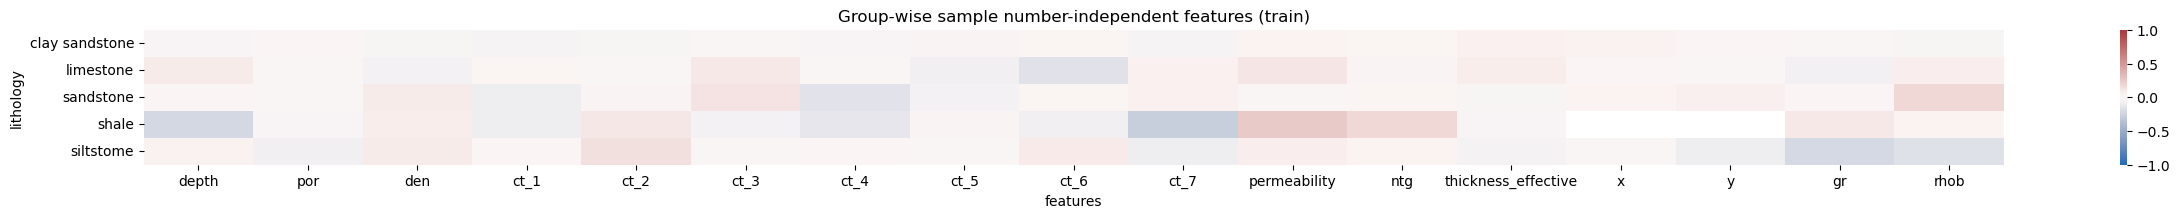

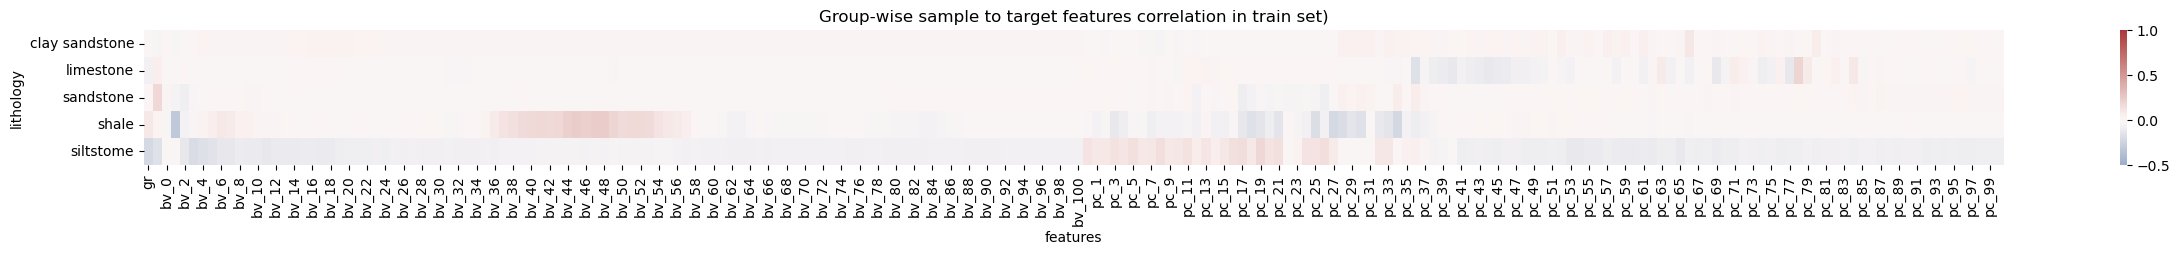

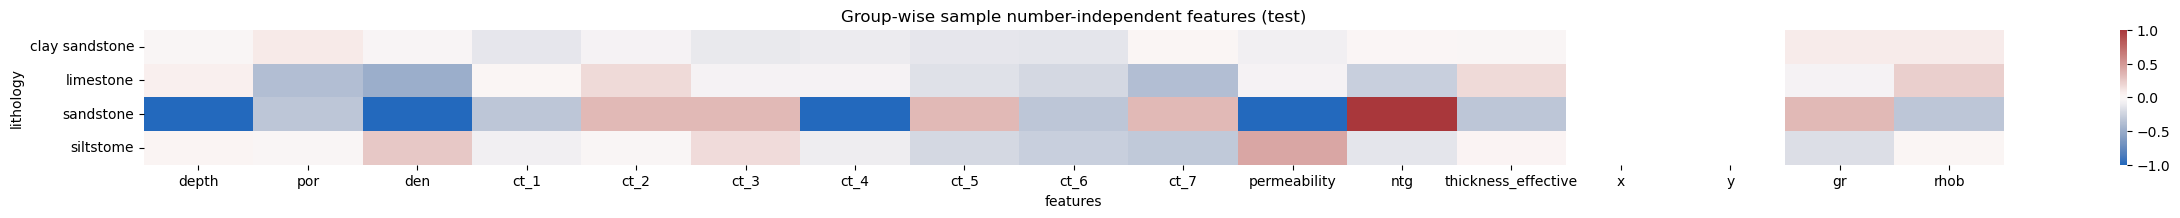

In [27]:
plt.figure(figsize=[30,1.75])
sns.heatmap(data_train.loc[:, :'rhob'].groupby('lithology').corr('kendall')['sample']
            .unstack().iloc[:,2:],vmin=-1, center=0, vmax=1, cmap='vlag').set(title='Group-wise sample number-independent features (train)', xlabel='features')
plt.show()

plt.figure(figsize=[30,1.75])
sns.heatmap(data_train.iloc[:, np.r_[1, 14, 17:222]].groupby('lithology').corr('kendall')['sample']
            .unstack().iloc[:,2:],vmin=-0.5, center=0, vmax=1, cmap='vlag').set(title='Group-wise sample to target features correlation in train set)', xlabel='features')
plt.show()

plt.figure(figsize=[30,1.75])
sns.heatmap(data_test.groupby(data_test.lithology).corr('kendall')['sample']
            .unstack().iloc[:,2:],vmin=-1, center=0, vmax=1, cmap='vlag').set(title='Group-wise sample number-independent features (test)', xlabel='features')
plt.show()

As we can see there is no relationship between sample number for target values, and train independent features. At the same time, for sandstone rock samples of test set there is a strong negative sample number correlation 
with depth, density, ct_4 and permeability features and strong positive with NTG. As long as sample feature is not correlated well with targets, we will not use it.

Most probably it is a spurious correlation, but some of them  supposedly were registered at wellsite  in  CT testing related order. Anyway the parameter doesn't impact much the target values generally so we can omit it in our study.

In [28]:
data_train.drop('sample', axis=1, inplace=True)
data_test.drop('sample', axis=1, inplace=True)

* #### $Independent$  $Features$  $Distributions$

Let's examine now distribution patterns for independent features. For the beginnning we will be guided by the following considerations:
1) Properties of core samples depend on depth as geostatcal pressure affects pore related properties. From this point of view the the nature of the relationship between the variables over the entire depth interval may give extrapolation results strongly deviating from the true values. For case of interpolation, care should be taken to not spoil model by irrelevant data (if some samples were taken from the same depth, have similar lithological type but have a different properties due to different formation histories affecting core properties). For this study we will use the data as is but for future work it looks reasonable to consider stratified sampling with different ratios.

2) Petrophysical properties depend on rock lithology. It means that whole set outliers may in fact be normal for lithological type it belongs to.

We need to check distribution of features for normality and outliers taking into account lithologies

In [29]:
feat_dict=dict()
data=data_train.iloc[:, :16]
# .drop(['lithology'],  axis=1)
for feature in data:
    shapiro_test_results=dict()
    normal_test_results=dict()
    for name, feat in data_train.groupby('lithology')[feature]:
        shapiro_test_results[name]=Normality_checker(feat, methods=['shapiro'])
        normal_test_results[name]=Normality_checker(feat, methods=['normaltest'])
    shapiro_df = pd.DataFrame.from_dict(shapiro_test_results, orient="index").round(2)
    normal_df = pd.DataFrame.from_dict(normal_test_results, orient="index").round(2)
    test_res=pd.concat([shapiro_df, normal_df], axis=1)
    feat_dict[feature]=test_res   

Now let's check our sample data for normality and outliers. 

In [30]:
test_results=pd.concat(feat_dict.values(), axis=1, keys=list(data.columns)).T.unstack()
test_results.style.background_gradient(cmap='PuBu', vmax=0.05).set_precision(3)
# sns.heatmap(test_results, cmap='vlag', vmin=0, vmax=0.1, center=0.05)

It is obvious from the results of the study that:

1) for clay sandstones normality assumption should be rejected, at least till the closer check for outliers

2) Permeability and gr data for all lithologies doesn't follow the normality law

3) The distributions of features for shale samples and samples of limestone (with exception of ct_6) are fit the law well

4) ct_7 samples (with exception of clay sandstone ones) are fitting well.

5) Porosity is distributed normally in all the lithologies with exception of shales and clay sandstones.

Let's check for type of distribution for each the feature

* #### Groups

Let's start with finding out how many wells do we have and where are they.

In [31]:
(data_train.group.value_counts(True).round(3)*100).reset_index().rename(columns=({'index': 'Group', 'group':'%'})).T

,0,1,2,3,4,5
Group,1.0,2.0,0.0,5.0,3.0,4.0
%,17.8,17.4,16.9,16.7,16.0,15.2


We have a very well balanced dataset of 6 wells and we can find spatial origin of our samples

In [32]:
wells=data_train.groupby('group')

wellcoords=wells[['x', 'y']].median()
display(wellcoords.T)

group,0,1,2,3,4,5
x,17349.0,20022.0,16169.0,18985.0,16790.0,19850.0
y,3782.0,3497.0,5288.0,5423.0,3644.0,3873.0


Plotting our wells in 3D and 2D

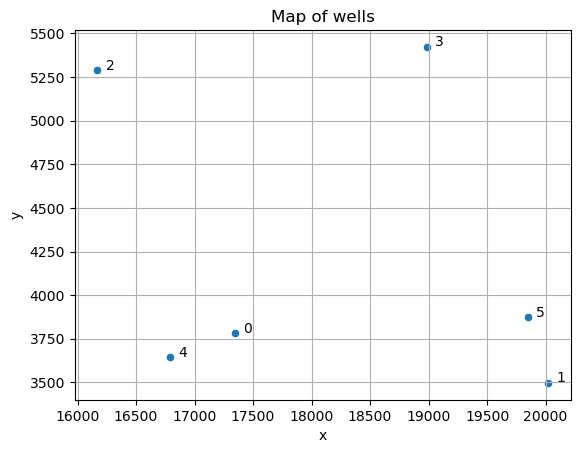

In [33]:
wellmap=sns.scatterplot(data=wellcoords, x="x", y="y")
wellmap.set(title='Map of wells' )
wellmap.grid(True)
[wellmap.annotate(wellcoords.index[i], (wellcoords.x[i]+70, wellcoords.y[i]+5))for i in (wellcoords.index)]
plt.show()

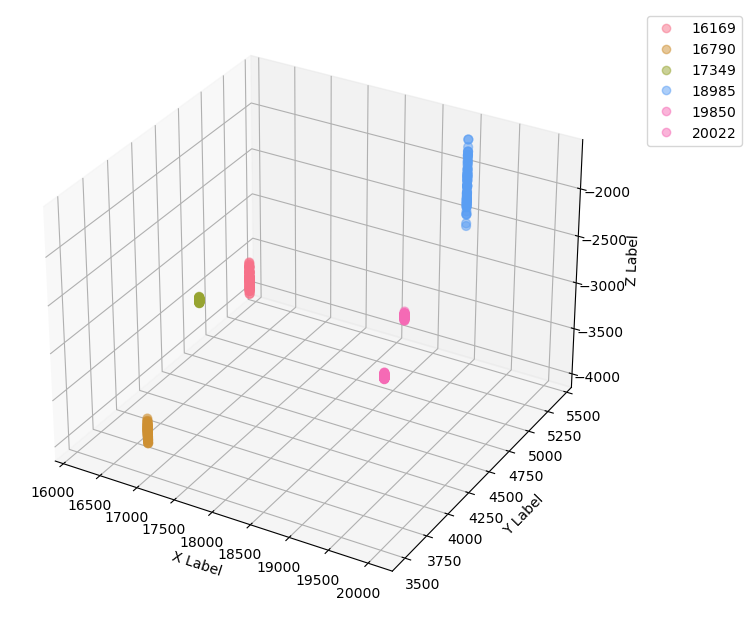

In [34]:
# generate data

x = data_train.x
y = data_train.y
z = -data_train.depth

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 16).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=x, marker='o', cmap=cmap, alpha=0.5)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

Stratigrahical columns for our wells

In [35]:
from striplog import Striplog, Component, Interval
from striplog import Legend

def well_log_plotter(df):
    
    """Lithological well log plotting"""
    log=df[['depth','lithology']].sort_values('depth')
    depth=log.depth
    lithotype=log.lithology.replace({'sandstone':0, 'siltstome':1,  'clay sandstone':2, 'shale':3, 'limestone':4})  
    KEY={0:'sandstone', 1:'siltstome',  2:'clay sandstone', 3:'shale', 4:'limestone'}
    intervals = []
    for top, base, lith in zip(depth, depth[1:], lithotype):
        comp = Component({'lithology': KEY[lith]})
        iv = Interval(top, base, components=[comp])
        intervals.append(iv)
    
    s = Striplog(intervals).merge_neighbours()  # Merge like with like.
    legend_csv = u"""colour, width, component lithology 
    #F7E9A6, 1, sandstone
    #bfbfa1, 1, siltstome
    #e0c369, 1, clay sandstone
    #5c3f11, 1, shale
    #ededeb, 1, limestone   
    """
    legend = Legend.from_csv(text=legend_csv)
    return s.plot(legend=legend, aspect=3, label='lithology')

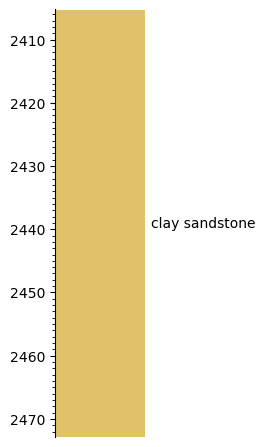

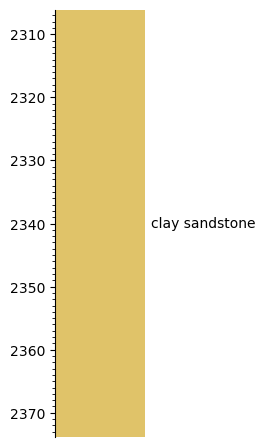

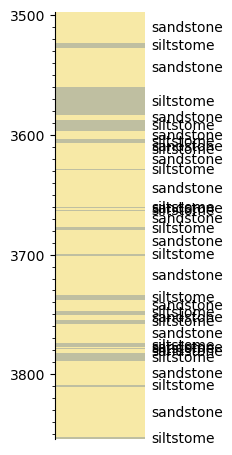

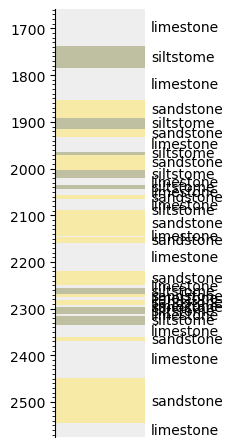

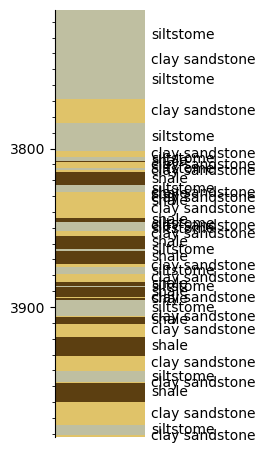

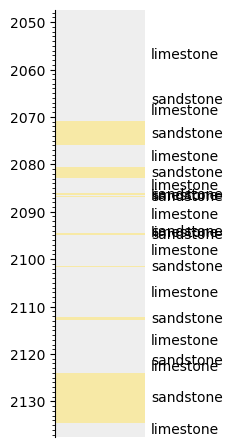

In [36]:
for i in range(0, 6):
    well_log_plotter(data_train[data_train['group']==i])
    

* #### $ Permeability $

So to begin we will look at permeability distribution for all set and for lithology grouped samples

**********************************PERMEABILITY*********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
lognorm,0.000,546.127,-6229.368,0.030,0.802
exponnorm,0.001,571.918,-5923.270,0.080,0.006
expon,0.001,564.534,-5887.885,0.078,0.008


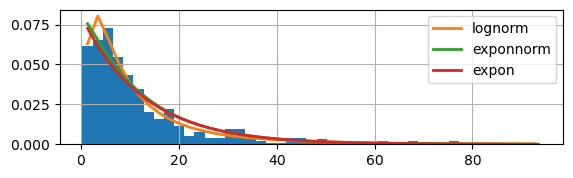

* IQR method with IQR coeff. values: [1.5, 1.5] is 36 which amounts 8 %


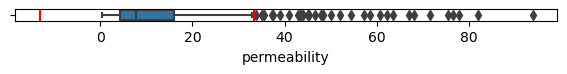

[6, 19, 35, 39, 47, 49, 58, 84, 104, 118, 128, 155, 192, 194, 209, 211, 212, 230, 232, 249, 257, 276, 281, 297, 298, 313, 318, 348, 380, 387, 390, 391, 417, 426, 432, 450]


In [37]:
print(distexaminer(data_train.permeability, 'IQR', Nbest=3, verbose=3))

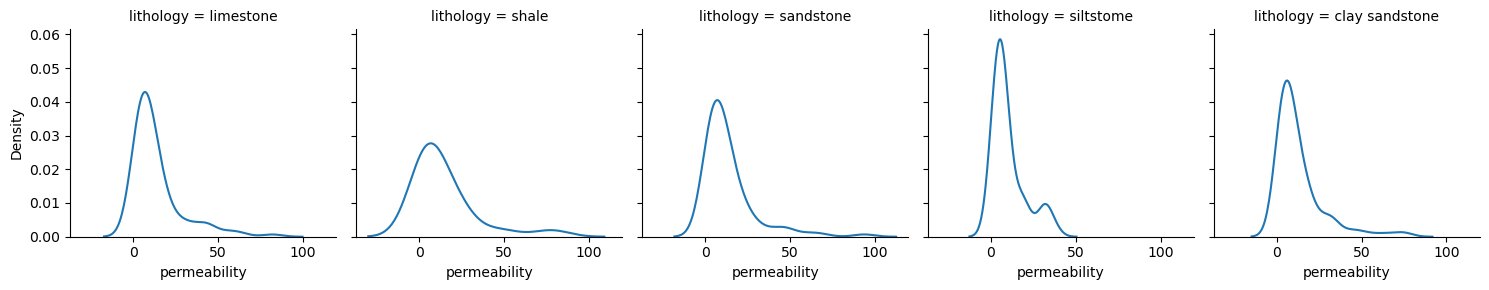

In [38]:
g =sns.FacetGrid(data_train, col='lithology')
g.map(sns.kdeplot, 'permeability')
plt.show()

We see that we have a lognormal distribution and we shouldn't remove any records before normalization.

Number of outliers is significant, but as long as the distribution is lognormal we shouldn't alleet it. We will transform the distribution to normal. 

In [39]:
data_train['permeability']=data_train['permeability'].apply(lambda x: np.log(x))

Let's examine shape of distribution for lithologies we received. We have a lognormal distribution and we will take a logarithm of the value with further distribution shape fitting.

**********************************PERMEABILITY*********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,0.207,211.429,-3490.163,0.025,0.934
lognorm,0.209,217.270,-3477.908,0.032,0.739
norm,0.209,214.282,-3483.774,0.033,0.699
exponnorm,0.209,216.279,-3477.652,0.033,0.699


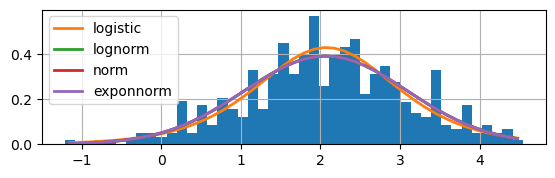

* IQR method with IQR coeff. values: [1.5, 1.5] is 3 which amounts 1 %


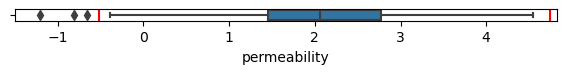

[166, 255, 370]


In [40]:
print(distexaminer(data_train['permeability'], 'IQR', Nbest=4, verbose=2))

We see that transformation returned not a normal but a logistic distribution. 1.5 coefficient at IQR value in IQR method covering 95% of normally distributed values
is too narrow for this kind of distribution having heavy tails at both sides. We will use Sigma method  with coefficient 3 that assures catching 99.7 % records of normally distributed feature

***********************************LIMESTONE***********************************
No outliers was found! 
 Acceptable values range by Sigma: [-1.0229299993061631, 5.249582869013029] 
 Observed values range: [-0.81, 4.41] 

*************************************SHALE*************************************
No outliers was found! 
 Acceptable values range by Sigma: [-1.4588283784197884, 5.544661613569677] 
 Observed values range: [0.2, 4.36] 

***********************************SANDSTONE***********************************
No outliers was found! 
 Acceptable values range by Sigma: [-0.8472310738979747, 5.13311290634142] 
 Observed values range: [-0.39, 4.54] 

***********************************SILTSTOME***********************************
No outliers was found! 
 Acceptable values range by Sigma: [-0.9303306858344345, 4.757396723771722] 
 Observed values range: [-0.66, 3.62] 

*********************************CLAY SANDSTONE********************************


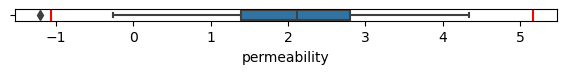

Outliers: [166] 

Total number of outliers: 1
[166]


In [41]:
print(distexaminer_lit('permeability', 'Sigma', Sigma_cf=[3, 3], Nbest=4, verbose=1))

We have only one low-perm sample in clay sandstone lithology. Let's drop it out

In [42]:
data_train.drop(166, inplace=True)

* #### $ Porosity $

**************************************POR**************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
lognorm,0.005,360.951,-5141.996,0.077,0.009
gamma,0.005,361.174,-5139.708,0.075,0.011
exponnorm,0.006,363.054,-5110.429,0.075,0.011
norm,0.006,361.108,-5116.197,0.076,0.010


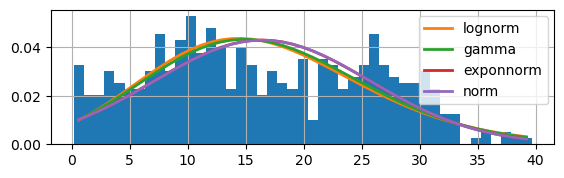

* IQR method with IQR coeff. values: [1.5, 1.5] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by IQR: [-13.76, 47.65] 
 Observed values range: [0.16, 39.65] 

None


In [43]:
print(distexaminer(data_train['por'], 'IQR', IQR_cf=[1.5, 1.5], Nbest=4, verbose=2))

Poroisity feature has at least two modes at 10 and 26% so we cannot treat it as normal one. At the same time It's crystal clear that there are several distinct types of rock and it would be quite surprising 
to have perfect normal distributions for all features of set containing e. g. both shales and sandstones.  Therefore we will examine the feature distribution lithology-wise.

***********************************LIMESTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
norm,0.018,330.839,-873.461,0.058,0.866
gamma,0.018,332.856,-868.826,0.058,0.867
lognorm,0.018,332.969,-868.734,0.057,0.880
logistic,0.019,334.479,-868.382,0.063,0.782
uniform,0.025,309.559,-840.020,0.139,0.036


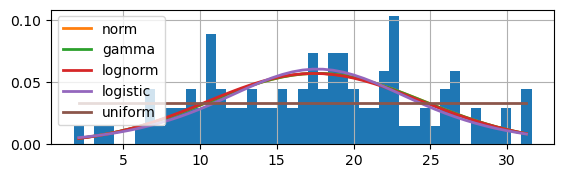

* IQR method with IQR coeff. values: [1.5, 1.5] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by IQR: [-4.24, 38.49] 
 Observed values range: [1.77, 31.59] 

*************************************SHALE*************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,0.996,252.649,-54.012,0.143,0.754
uniform,1.015,213.555,-53.626,0.338,0.015
lognorm,1.016,244.984,-50.615,0.140,0.777
norm,1.016,242.576,-53.603,0.141,0.768
exponnorm,1.016,244.576,-50.607,0.141,0.768


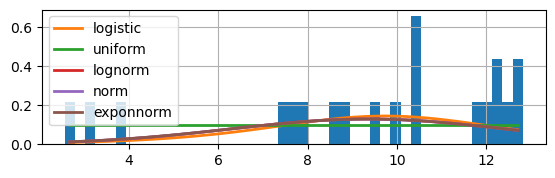

* IQR method with IQR coeff. values: [1.5, 1.5] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by IQR: [1.69, 18.15] 
 Observed values range: [2.56, 12.82] 

***********************************SANDSTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
gamma,0.011,359.946,-834.713,0.067,0.772
lognorm,0.011,360.548,-834.207,0.071,0.709
exponnorm,0.012,362.212,-832.546,0.077,0.607
norm,0.012,359.956,-836.779,0.076,0.616
logistic,0.012,363.570,-832.966,0.075,0.637


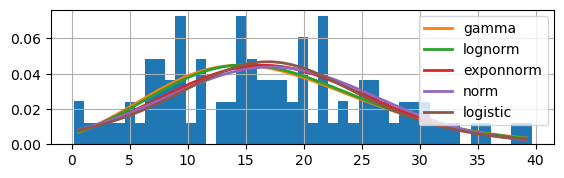

* IQR method with IQR coeff. values: [1.5, 1.5] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by IQR: [-11.84, 45.1] 
 Observed values range: [0.17, 39.65] 

***********************************SILTSTOME***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
gamma,0.036,327.078,-357.692,0.074,0.927
lognorm,0.037,327.236,-357.500,0.073,0.931
exponnorm,0.038,326.749,-356.155,0.086,0.815
norm,0.038,324.498,-359.905,0.089,0.781
logistic,0.038,328.986,-359.175,0.080,0.876


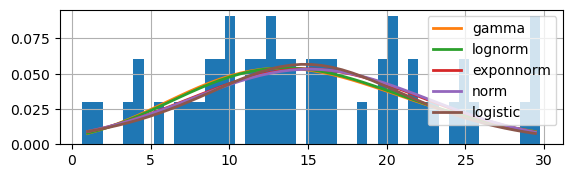

* IQR method with IQR coeff. values: [1.5, 1.5] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by IQR: [-5.95, 36.12] 
 Observed values range: [0.67, 29.77] 

*********************************CLAY SANDSTONE********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
uniform,0.015,330.483,-1756.561,0.141,0.001
expon,0.016,359.018,-1737.161,0.173,0.000
lognorm,0.020,351.481,-1694.387,0.165,0.000
gamma,0.020,350.617,-1689.854,0.151,0.000
exponnorm,0.021,350.606,-1689.109,0.149,0.000


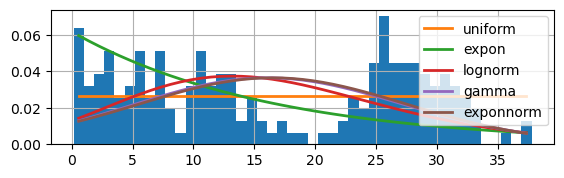

* IQR method with IQR coeff. values: [1.5, 1.5] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by IQR: [-24.21, 57.53] 
 Observed values range: [0.16, 37.78] 

Total number of outliers: 0


[]

In [44]:
distexaminer_lit(feature='por', method='IQR', verbose=3, Nbest=5)

As we can see all groups of lithologies can be fitted by normal or other distribution while porosity distribution of clay sandstones still has 2-3 modes. There are no outlying records 

For all the lithology types we have a good fitting by lognormal distribution curve and it means we need to transform the data and only after that we can remove the outliers

Only 3 samples are out of the range, and we drop them.

Now we will examine other features

* ##### $Depth $

Let's examine depth values distributions for groups

Text(0.5, 0.98, 'Sampling depth for groups')

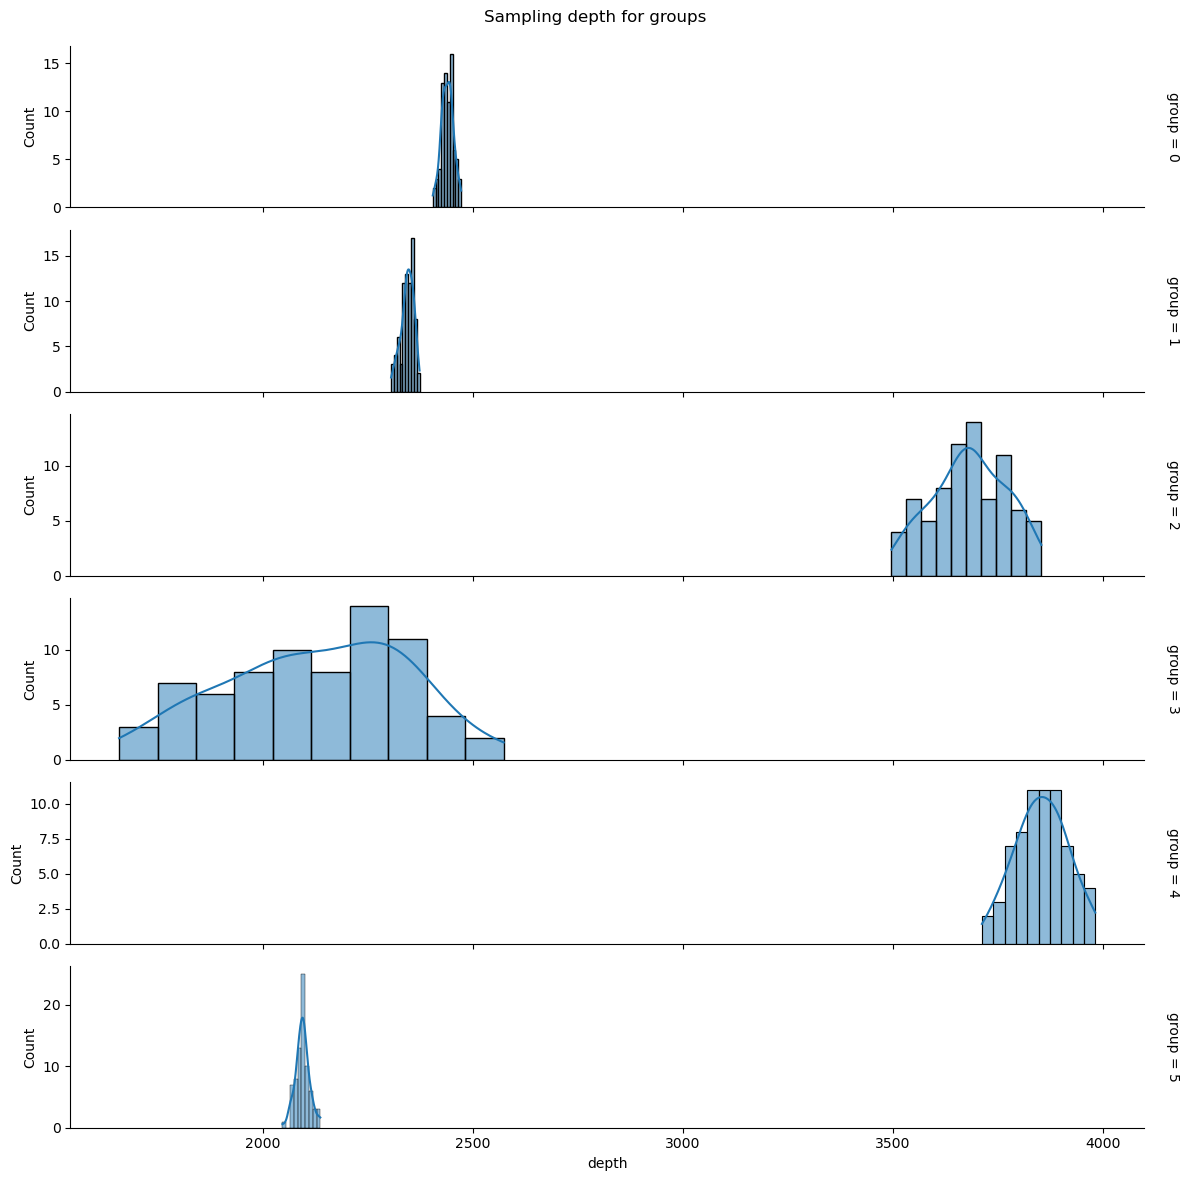

In [45]:
fg=sns.FacetGrid(data_train, row= "group",  height=2, aspect=6, sharex=True, sharey=False, margin_titles=True)
fg.map(sns.histplot, "depth", bins=10, kde=True)

fg.fig.subplots_adjust(top=0.95) 
fg.fig.suptitle('Sampling depth for groups')

As we can see from the hisograms:

1) The core testing intervals for wells #0 and #1 are looking very similar
2) There is a very long sampling gap in range 2500-3500 meters that splits wells into 2 groups: "shallow reservoirs": # (0, 1, 3 and 5) and "deep reservoirs" (2, 4)
3) Well # 3 has the widest sampling interval, it looks that we have a samples from a massive type reservoir. 

Now it's time to look at lithologies of cores.

What can we see at the plot is we have two distinct sampling depth ranges with a huge gap in range arr. 2550-3250 meters. Taking into account that pore related feateares are controlled geostatically,
we can expect that rows in these to separate strata will have some differences related to the depth of origin.

*************************************DEPTH*************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
exponnorm,0.0,737.255,-7658.690,0.205,0.0
lognorm,0.0,740.012,-7638.852,0.207,0.0
gamma,0.0,723.575,-7622.441,0.245,0.0
uniform,0.0,701.587,-7603.821,0.319,0.0


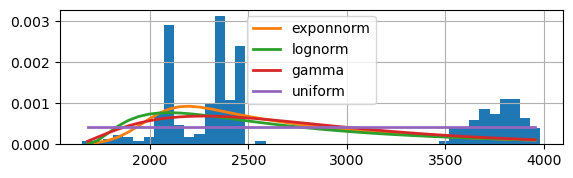

No outliers was found! 
 Acceptable values range by IQR: [-139.56, 5956.93] 
 Observed values range: [1658.52, 3982.32] 



In [46]:
distexaminer(data_train['depth'], 'IQR', Nbest=4, verbose=1)

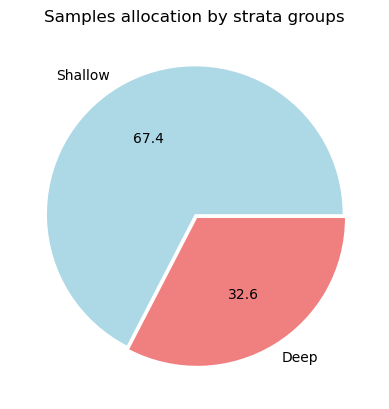

In [47]:
data_train['bindepth']=np.where(data_train.depth>3000, 1, 0)

plt.pie(data_train['bindepth'].value_counts().round(2), labels=['Shallow', 'Deep'], autopct='%.1f', explode=(0, 0.03), colors=['lightblue', 'lightcoral'])
plt.title('Samples allocation by strata groups')

plt.show()

In [48]:
mms=MinMaxScaler()
data_train['norm_depth']=mms.fit_transform(data_train[['depth']])
data_test['norm_depth']=mms.transform(data_test[['depth']])
# data_train['norm_depth']

Let's have a look at depth distribution after separate strata-wise examination. From the results below we see that each 3rd sample belongs to deeper strata (core sampling depth>3000 m).

The outlier catcher method doesn't found any outliers, that is supported by fact that this feature values range looks valid (depth range is typical for oilfield reservoirs).

We can see that all of them from shallow reservoirs. The questions we have now are:

1) if properties of lower and upper stages are similar?

2) Do they differ to properties of test population of samples?

To answer the question let's have a look at median values for values in lower/upper formations of train set and medians for test set feaures.

In [49]:
depth_split=data_train.iloc[:, np.r_[1:17, 219]].groupby([data_train['depth']>3000, 'lithology']).median().round(2)
depth_split=depth_split.rename(index={False:'Train set shallow reservoirs', True: "Train set deep reservoirs"})
test_solid=pd.concat([data_test.iloc[:, np.r_[1:17]].groupby('lithology').median().round(2)], keys=['Test set reservoirs'])
pd.concat([depth_split, test_solid]).T

depth               Train set shallow reservoirs                      \
lithology                         clay sandstone limestone sandstone   
depth                                    2368.77   2096.51   2112.25   
por                                        22.00     18.16     14.76   
den                                         2.71      2.70      2.71   
ct_1                                     2457.71   2364.33   2391.81   
ct_2                                     2421.53   2366.39   2345.17   
ct_3                                     2435.62   2407.40   2432.29   
ct_4                                     2411.91   2436.34   2406.79   
ct_5                                     2401.43   2403.83   2391.86   
ct_6                                     2434.27   2440.61   2558.17   
ct_7                                     2438.01   2360.51   2383.63   
permeability                                2.16      2.13      2.09   
ntg                                         0.49      0.47      0.58   
thickness_effective                         6.15      6.68      5.91   
x                                       20022.00  19850.00  18985.00   
y                                        3497.00   3873.00   5423.00   
pc_99                                   52226.90  52201.25  52198.95   

depth                         Train set deep reservoirs                      \
lithology           siltstome            clay sandstone sandstone     shale   
depth                 2062.90                   3836.19   3679.35   3868.89   
por                     15.63                     10.54     19.73     10.22   
den                      2.69                      2.77      2.79      2.79   
ct_1                  2255.64                   2536.14   2118.30   2603.08   
ct_2                  2445.25                   2603.60   2120.65   2705.10   
ct_3                  2234.67                   2585.50   2029.66   2588.39   
ct_4                  2451.81                   2614.87   2140.97   2555.48   
ct_5                  2389.01                   2672.61   2149.78   2676.37   
ct_6                  2529.67                   2678.08   2110.15   2634.20   
ct_7                  2451.43                   2596.64   2054.22   2524.82   
permeability             1.82                      1.55      2.29      1.92   
ntg                      0.50                      0.29      0.55      0.34   
thickness_effective      5.22                      5.72      5.52      5.31   
x                    18985.00                  16790.00  16169.00  16790.00   
y                     5423.00                   3644.00   5288.00   3644.00   
pc_99                52223.67                   8205.60   9037.75   8231.65   

depth                         Test set reservoirs                      \
lithology           siltstome      clay sandstone limestone sandstone   
depth                 3773.61             2518.02   2515.86   2508.86   
por                     12.71               15.87     12.43     13.46   
den                      2.82                2.70      2.68      2.70   
ct_1                  2318.91             2382.12   2397.86   2266.05   
ct_2                  2327.78             2414.56   2296.29   2334.53   
ct_3                  2477.38             2353.76   2419.64   2213.71   
ct_4                  2499.23             2384.26   2477.30   2583.17   
ct_5                  2284.69             2396.92   2401.32   2373.29   
ct_6                  2350.78             2391.64   2222.44   2321.13   
ct_7                  2428.56             2411.07   2396.67   2459.39   
permeability             1.88                5.89      8.48      2.29   
ntg                      0.52                0.48      0.33      0.35   
thickness_effective      5.80                7.86      8.67      7.77   
x                    16169.00            19250.00  19250.00  19250.00   
y                     5288.00             4113.00   4113.00   4113.00   
pc_99                 8643.85          

What can we see from the data (keeping in mind that we looking at median without consideration of standard deviation)?

1) For clay sandstone and siltstone porosity, permeability, ntg and effective thickness are decreasing with depth (compaction is compaction, this comes as no surprise).
2) For sandstones and siltstones porosity decreases while permeability rises (effect of fracture?)
3) Densities increase with depth occures for all the lithologies
4) Deeper formations don't have limestonic rocks while shallower doesn't contain shales. If reletionship between shale properties and properties of other lithologies are quite another, 
the data may have a negative impact on prediction power of our model. 
5) Test data sets samples has much higher value of permeabilities and effective thickness, while densities they have are close to ones we see in case of shallow samples of the same depth. 

Taking into account all said  above, there is a risk that  we cannot treat features in our train data_set as normally distributed.

In order to understand if difference between 3 sets (train_shallow, train_deep, test)there is a statistically significant  we will make round robin T-tests.

In [50]:
from statsmodels.stats.weightstats import ttest_ind

In [51]:
[*train_sets]=[i[1] for i in data_train.iloc[:, np.r_[0:19, 221:223]].groupby(data_train['depth']<3000)]
# train_sets[0]

In [52]:
# Train set upper and lower parts
intralit=set(train_sets[0].lithology.unique()).intersection(train_sets[1].lithology.unique())
ttlist=[]
for lit in intralit:
    top=train_sets[0][train_sets[0].lithology==lit].drop(["lithology", "depth"], axis=1)
    bottom=train_sets[1][train_sets[1].lithology==lit].drop(["lithology", "depth"], axis=1)
    ttest_res=ttest_ind(top, bottom)[1]
    ttframe=pd.DataFrame(ttest_res, index=data_train.columns[np.r_[0:19, 221:223]].drop(["lithology", "depth"])).round(3).T
    ttlist.append(ttframe)
ttres=pd.concat(ttlist)
ttres.index=intralit
display(ttres.style.background_gradient(cmap=cm, axis=None).set_precision(3))

,group,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,permeability,ntg,thickness_effective,x,y,gr,rhob,bindepth,norm_depth
siltstome,0.931,0.707,0.000,0.745,0.295,0.201,0.276,0.841,0.092,0.887,0.451,0.992,0.357,0.000,0.000,0.468,0.805,0.000,0.000
sandstone,0.000,0.078,0.000,0.005,0.032,0.000,0.000,0.000,0.000,0.000,0.647,0.723,0.235,0.000,0.000,0.001,0.546,0.000,0.000
clay sandstone,0.000,0.001,0.162,0.039,0.043,0.115,0.018,0.000,0.001,0.049,0.079,0.003,0.209,0.000,0.783,0.067,0.018,0.000,0.000


As we can see we can rely on permeability, thickness_effective data for both groups of train test reservoirs we can't reject H0 hypothesis about absence of difference. 

At the same time we have statistically significant differences in porosity, ntg and resistance for the lower and upper clay sandstone formations, and much stronger dissimilarities in sandstone rock properties.
For ct group of parameters we can see that the values for depth groups will be different, gr is also quite different for these depth groups. The only rock type that doesn't change it's behavior with the depth is siltsnone. Densities for sandstones and siltstones are statistically different. 

Next check will be done for train an test strata on depth <3000.

In [53]:
data_test.columns[:16]

Index(['group', 'depth', 'por', 'den', 'ct_1', 'ct_2', 'ct_3', 'ct_4', 'ct_5',
       'ct_6', 'ct_7', 'permeability', 'ntg', 'thickness_effective', 'x', 'y'],
      dtype='object')

In [54]:
data_test['bindepth']=0

In [55]:
# Train set upper and test.remove()
intralit=set(train_sets[0].lithology.unique()).intersection(data_test.lithology.unique())
ttlist=[]
for lit in intralit:
    train_u=train_sets[0][train_sets[0].lithology==lit].drop(["lithology", "depth"], axis=1) 
    test=data_test[data_test.lithology==lit].drop(["lithology", "depth"], axis=1) 
    ttest_res=ttest_ind(train_u, test)[1]
    ttframe=pd.DataFrame(ttest_res, index=data_train.columns[np.r_[0:19, 221:223]].drop(["lithology", "depth"])).round(3).T
    ttlist.append(ttframe)
ttres_tr=pd.concat(ttlist)
ttres_tr.index=intralit
ttres_tr.style.background_gradient(cmap=cm, axis=None).set_precision(3)

,group,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,permeability,ntg,thickness_effective,x,y,gr,rhob,bindepth,norm_depth
siltstome,0.000,0.799,0.000,0.332,0.625,0.722,0.746,0.147,0.429,0.573,0.000,0.181,0.000,0.000,0.090,0.063,0.579,0.000,0.000
sandstone,0.000,0.540,0.008,0.388,0.494,0.613,0.034,0.400,0.116,0.102,0.000,0.239,0.005,0.000,0.000,0.117,0.856,0.000,0.000
clay sandstone,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.005,0.063,0.000,0.000,0.000,0.000,0.010,0.000,0.000


In this comparison we see that we have very significant differences in clay sandstones properties for train and test samples of the same depth formations. It means that features we use for modelling clay sands in train reservoirs 
may fail when used for sandstones well # 6. Permeability values, densities and effective thicknesses are also significantly different for all the lithologies available in both the reservoirs. At the same time, sandsones and siltstones 
in test and train reservoirs show no statistical difference.

Now we will make this T-test check with upper train set and test set

In [56]:
# Train set lower and test
intralit=set(train_sets[1].lithology.unique()).intersection(data_test.lithology.unique())
ttlist=[]
for lit in intralit:
    train_u=train_sets[1][train_sets[1].lithology==lit].drop(["lithology"], axis=1)
    test=data_test[data_test.lithology==lit].drop("lithology", axis=1)
    ttest_res=ttest_ind(train_u, test)[1]
    ttframe=pd.DataFrame(ttest_res, index=data_train.columns[np.r_[0:19, 221:223]].drop(["lithology"])).round(3).T
    ttlist.append(ttframe)
ttres_tr=pd.concat(ttlist)
ttres_tr.index=intralit
ttres_tr.iloc[:,1:].style.background_gradient(cmap=cm, axis=None).set_precision(3)

,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,permeability,ntg,thickness_effective,x,y,gr,rhob,bindepth,norm_depth
siltstome,0.000,0.510,0.877,0.423,0.360,0.120,0.374,0.089,0.019,0.515,0.036,0.311,0.000,0.000,0.000,0.132,0.721,0.000,0.000
limestone,0.000,0.159,0.106,0.815,0.589,0.745,0.802,0.818,0.085,0.678,0.000,0.383,0.002,0.043,0.201,0.674,0.521,0.000,0.000
sandstone,0.000,0.973,0.594,0.909,0.933,0.229,0.508,0.589,0.458,0.902,0.001,0.240,0.108,0.977,0.062,0.814,0.973,0.000,0.000
clay sandstone,0.000,0.170,0.000,0.112,0.149,0.001,0.077,0.098,0.030,0.042,0.000,0.299,0.000,0.001,0.000,0.776,0.850,0.000,0.000


It's surprising a bit to see that test set features pattern is closer to deeper formations of train set than to shallower strata of train samples data set having the same depth magnitude. 
The possible reason is that we have a different sedimentation conditions for shallow reservoirs rocks presnted in train and test sets, and rocks identical/close to 
rocks we can see in test dataset are located in higher depth in train set samples zone or provably we have a fault or some kind of inverted/flat-topped folds.

Finally we will look at diffferences in target values

And what about train set sampling depth? 

*************************************DEPTH*************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,0.005,418.687,-989.229,0.052,0.937
norm,0.005,415.905,-987.972,0.059,0.854
exponnorm,0.005,417.905,-983.367,0.059,0.854
gamma,0.005,416.672,-981.554,0.068,0.717


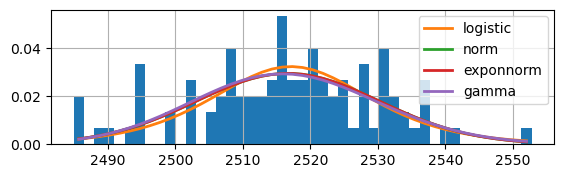

No outliers was found! 
 Acceptable values range by IQR: [2480.9, 2554.56] 
 Observed values range: [2484.95, 2552.75] 

None


In [57]:
print(distexaminer(data_test['depth'], 'IQR', Nbest=4, verbose=1))

<!-- For the next, let's have a look at feature distributions for clay sands -->

As we can see clay sandsones of different stratas sampled for train set differs significantly in bulk volume target feature values.
Capplilary pressure data are statistically different for all kinds of lithology.
the lowest differences in bulk volume we see for bulk volume ponts 16-100 for siltstones as well as bv 6-9 for sandstones.

As long as we found a statistically significan difference in MICP results, and taking into account that clay sandstones in shallower reservoirs are dissimilar to the same type rocks in test reservoirs, we can expect higher error for this type. It can be probably mitigated by stratified samplinng of initial train data set.

Now, when we have an understanding on feature spatial variation we will examine other features

In [58]:
data_train.drop(['group', 'x', 'y'], axis=1, inplace=True)
data_test.drop(['group', 'x', 'y'], axis=1, inplace=True)

* #### $ den $

**************************************DEN**************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
exponnorm,141.624,4.956,-510.519,0.095,0.001
lognorm,169.115,-0.787,-429.979,0.118,0.000
gamma,174.281,-1.835,-416.318,0.122,0.000


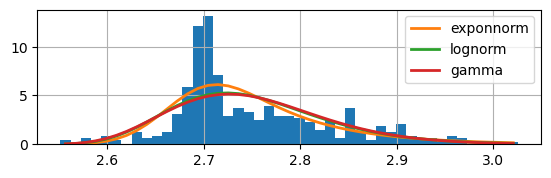

* IQR method with IQR coeff. values: [1.5, 1.5] is 10 which amounts 2 %


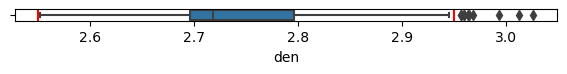

[25, 80, 112, 120, 216, 267, 429, 433, 434, 446]


In [59]:
print(distexaminer(data_train.den, method="IQR"))

We see that we have mixed lithologies effect again. Therefore we will look at densities distribution for each lithologies (as we can see below the distribution is logistic, so Sigma method would be more adequate for the feature) 

***********************************LIMESTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,792.961,-33.060,218.432,0.118,0.106
exponnorm,1061.543,-24.247,252.811,0.147,0.022
lognorm,1104.448,-32.431,256.852,0.154,0.014


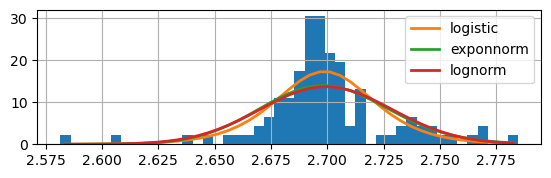

* Z-score method with sigma coeff. values: [3, 3] is 2 which amounts 2 %


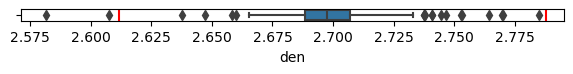

Outliers: [10, 151] 

*************************************SHALE*************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,1383.103,-74.499,90.719,0.099,0.978
gamma,1397.386,-78.453,93.920,0.119,0.906
lognorm,1398.904,-78.529,93.941,0.115,0.925


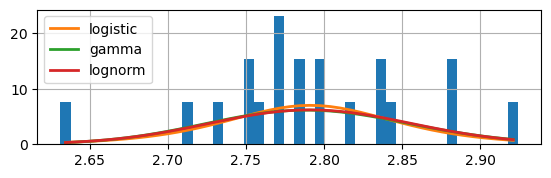

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [2.5923120122745944, 2.9909839916209693] 
 Observed values range: [2.63, 2.92] 

***********************************SANDSTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
lognorm,132.595,-49.397,45.966,0.052,0.950
gamma,133.069,-50.192,46.302,0.050,0.962
exponnorm,135.672,-47.287,48.123,0.059,0.875


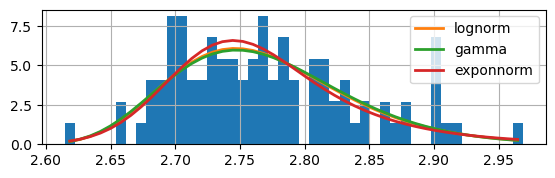

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [2.5584523351622397, 2.9799864522976187] 
 Observed values range: [2.61, 2.97] 

***********************************SILTSTOME***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
norm,385.307,-77.308,110.997,0.087,0.806
exponnorm,385.362,-75.300,114.936,0.087,0.807
gamma,386.870,-75.330,115.135,0.084,0.835


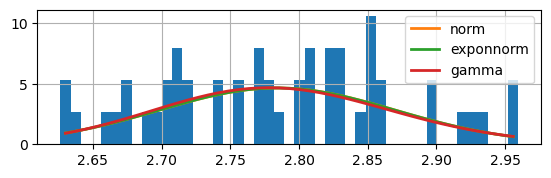

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [2.524063296400191, 3.0442275514216077] 
 Observed values range: [2.63, 2.96] 

*********************************CLAY SANDSTONE********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
exponnorm,257.832,-16.931,75.758,0.127,0.004
lognorm,281.439,-22.862,92.140,0.150,0.000
gamma,284.743,-23.801,94.323,0.152,0.000


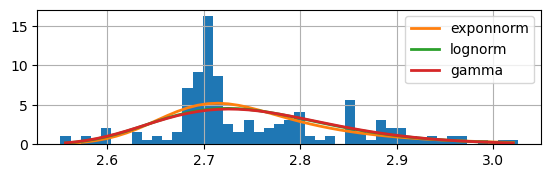

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [2.4715830343052905, 3.0367747178930524] 
 Observed values range: [2.55, 3.03] 

Total number of outliers: 2
[10, 151]


In [60]:
print(distexaminer_lit('den', method="Sigma"))

In [61]:
data_train.drop([10, 151], inplace=True)

* #### $CT-series$

Now let's look at ct series of features relationship to bulk volume and capillary pressure values

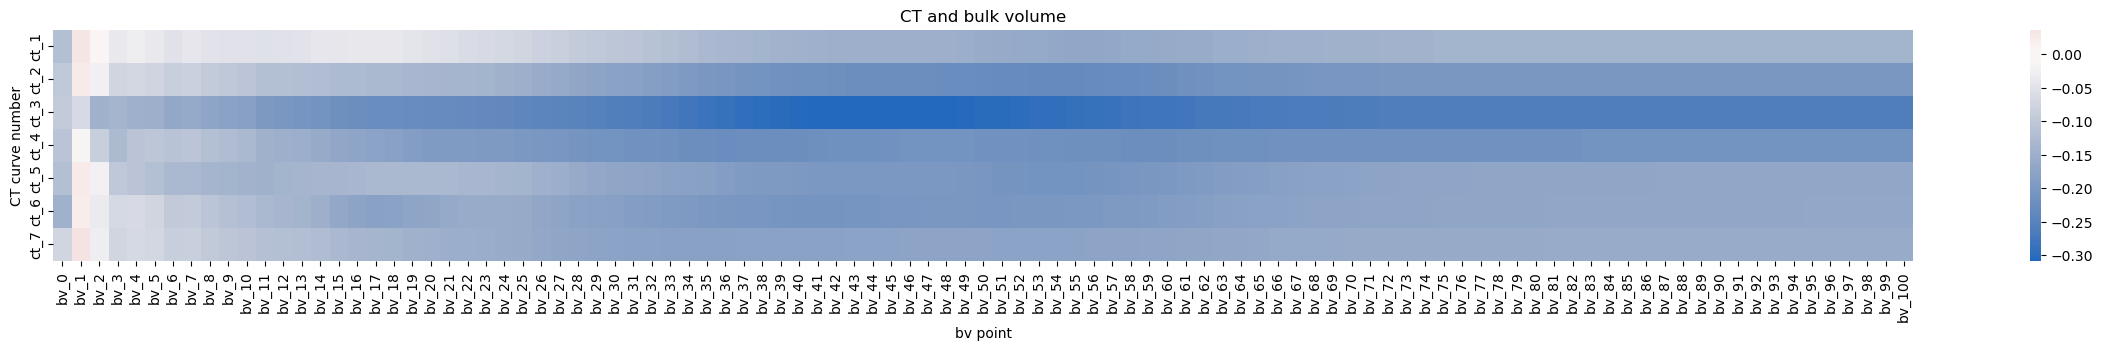

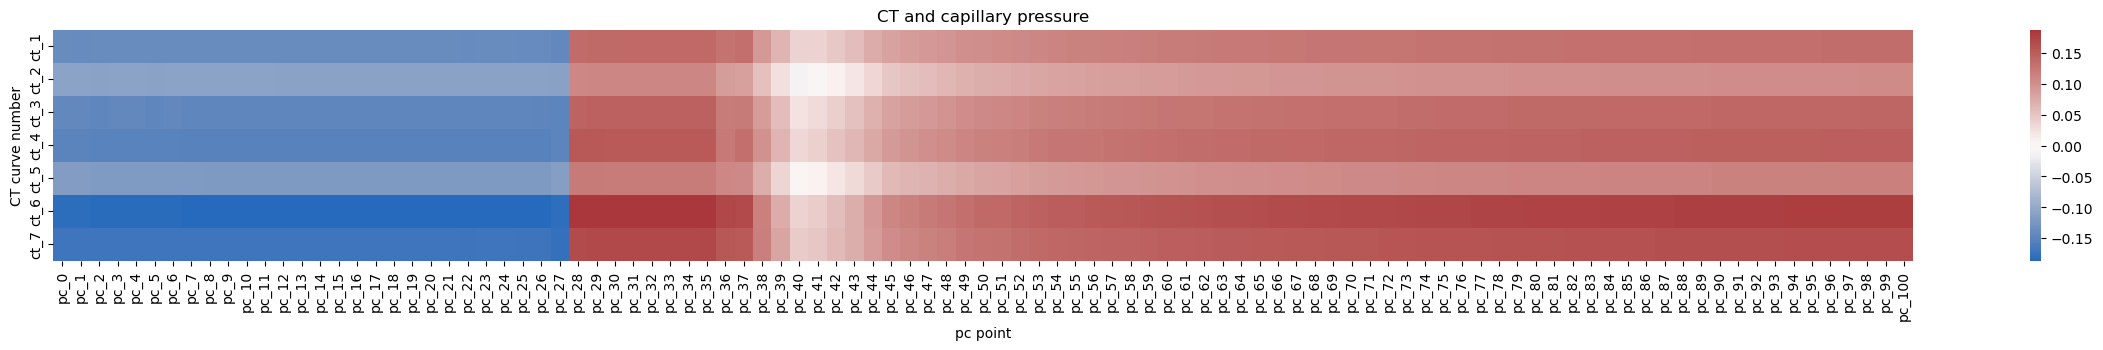

In [62]:
plt.figure(figsize=[30,3])    
sns.heatmap(data_train.filter(regex='ct_').join(data_train.iloc[:, 16:]).corr().iloc[:7, 7:108], center=0, cmap='vlag').set(title='CT and bulk volume', xlabel='bv point', ylabel='CT curve number')
plt.show()

plt.figure(figsize=[30,3])    
sns.heatmap(data_train.filter(regex='ct_').join(data_train.iloc[:, 16:]).corr().iloc[:7, 108:-2], center=0, cmap='vlag').set(title='CT and capillary pressure', xlabel='pc point', ylabel='CT curve number')
plt.show()

As we can see CT data correlation with bv_points is  higher than correlation with cp_points values, the highest correlation is observed in ct_3 feature case

We will try to use scaled CT data

In [63]:
mms=MinMaxScaler()

data_train.loc[:,'ct_1':'ct_7']=mms.fit_transform(data_train.loc[:,'ct_1':'ct_7'])
display(data_train.loc[:,'ct_1':'ct_7'].head())
data_test.loc[:,'ct_1':'ct_7']=mms.fit_transform(data_test.loc[:,'ct_1':'ct_7'])
display(data_test.loc[:,'ct_1':'ct_7'].head())

,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7
0,0.352205,0.663142,0.689406,0.328929,0.406440,0.616953,0.444756
1,0.574940,0.879850,0.515581,0.503384,0.708561,0.875195,0.641331
2,0.476894,0.192952,0.757011,0.616214,0.541857,0.461072,0.650129
3,0.271883,0.655265,0.639750,0.654256,0.756704,0.430989,0.553819
4,0.276613,0.482741,0.696802,0.174535,0.488310,0.399212,0.082551


,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7
0,0.511111,0.679890,0.531787,0.521590,0.501104,0.358751,0.544660
1,0.607143,0.506240,0.477484,0.130755,0.703464,0.003685,0.269531
2,0.466165,0.712365,0.238241,0.375044,0.361853,0.692688,0.491624
3,0.691912,0.535034,0.676659,0.552867,0.711611,0.609911,0.561519
4,0.480174,0.492149,0.203486,1.000000,0.977981,0.355436,0.478294


Let's have a look now on CT features distributions.

***********************************LIMESTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,28.735,43.735,-115.496,0.048,0.965
exponnorm,31.461,40.998,-101.826,0.070,0.682
lognorm,33.292,41.389,-96.171,0.074,0.615


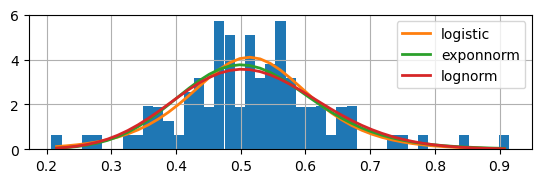

* Z-score method with sigma coeff. values: [3, 3] is 1 which amounts 1 %


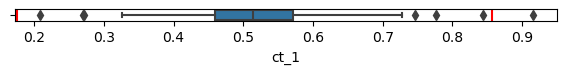

Outliers: [81] 

*************************************SHALE*************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,923.592,-47.136,82.642,0.190,0.413
exponnorm,934.143,-50.096,85.865,0.186,0.438
lognorm,952.280,-54.859,86.250,0.204,0.332


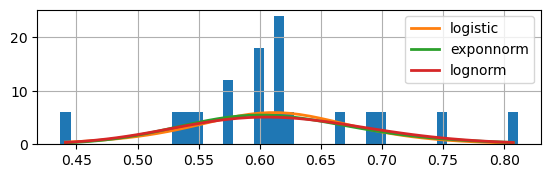

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.3714274158613524, 0.8600581757929631] 
 Observed values range: [0.44, 0.81] 

***********************************SANDSTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,49.684,18.789,-50.848,0.051,0.958
norm,52.161,13.768,-46.276,0.092,0.383
exponnorm,52.161,15.768,-41.733,0.092,0.383


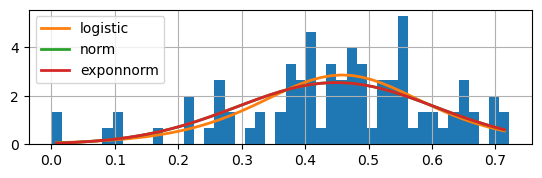

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [-0.022932109190529626, 0.9202501326991526] 
 Observed values range: [0.0, 0.72] 

***********************************SILTSTOME***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
lognorm,32.848,26.968,-10.640,0.057,0.994
norm,32.872,24.874,-14.535,0.058,0.991
exponnorm,32.872,26.874,-10.603,0.058,0.991


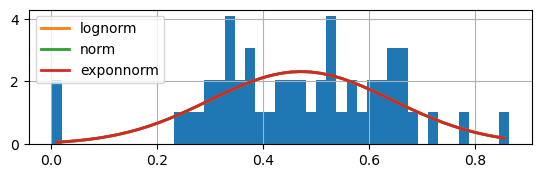

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [-0.05057157603361023, 0.993058697224461] 
 Observed values range: [0.0, 0.86] 

*********************************CLAY SANDSTONE********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,35.278,76.279,-301.426,0.061,0.482
exponnorm,43.944,72.128,-255.117,0.083,0.139
lognorm,46.100,83.357,-246.160,0.079,0.187


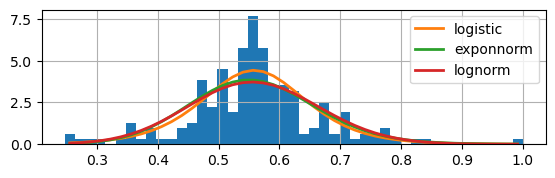

* Z-score method with sigma coeff. values: [3, 3] is 1 which amounts 1 %


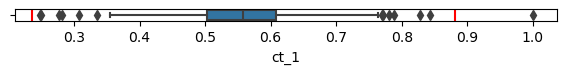

Outliers: [152] 

Total number of outliers: 2
***********************************LIMESTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,76.416,-13.127,-17.687,0.063,0.806
exponnorm,81.900,-16.010,-6.152,0.082,0.483
lognorm,88.854,-20.028,1.998,0.085,0.448


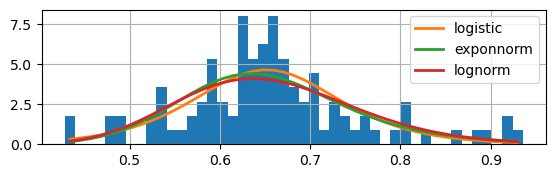

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.3544892798978621, 0.9589752150714499] 
 Observed values range: [0.43, 0.94] 

*************************************SHALE*************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,642.763,-39.881,75.392,0.124,0.883
lognorm,664.449,-46.082,79.052,0.137,0.802
norm,664.719,-48.517,76.064,0.137,0.798


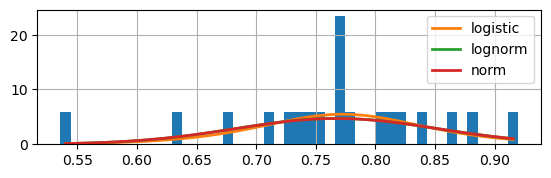

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.5067171750106082, 1.0282747222746482] 
 Observed values range: [0.54, 0.92] 

***********************************SANDSTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,17.051,70.686,-151.381,0.059,0.874
norm,19.238,75.457,-140.035,0.087,0.455
exponnorm,19.238,77.456,-135.491,0.087,0.455


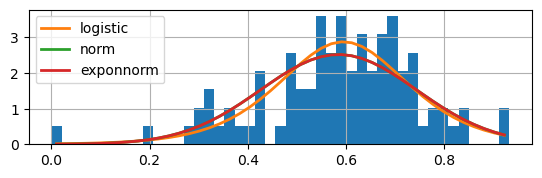

* Z-score method with sigma coeff. values: [3, 3] is 1 which amounts 1 %


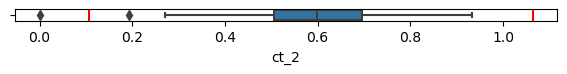

Outliers: [381] 

***********************************SILTSTOME***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
norm,130.715,-32.357,55.864,0.114,0.485
exponnorm,130.716,-30.357,59.797,0.114,0.484
lognorm,131.072,-30.261,59.936,0.117,0.458


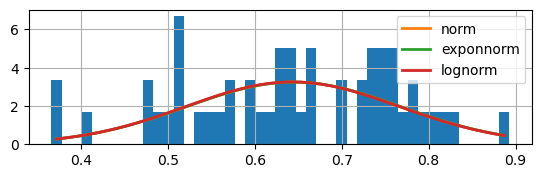

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.27239607694275925, 1.0165349061183564] 
 Observed values range: [0.37, 0.89] 

*********************************CLAY SANDSTONE********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
exponnorm,39.061,50.353,-277.146,0.071,0.282
lognorm,42.091,45.317,-263.174,0.087,0.108
gamma,42.583,43.790,-261.001,0.090,0.094


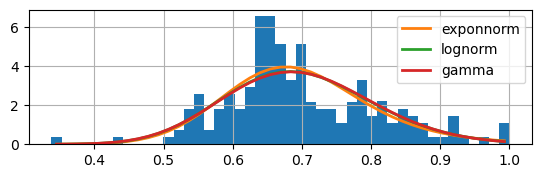

* Z-score method with sigma coeff. values: [3, 3] is 1 which amounts 1 %


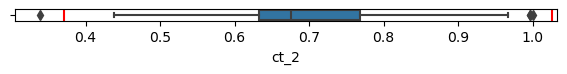

Outliers: [150] 

Total number of outliers: 2
***********************************LIMESTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,17.760,94.606,-163.613,0.043,0.989
exponnorm,19.975,120.127,-147.254,0.065,0.770
lognorm,20.489,112.197,-144.713,0.072,0.654


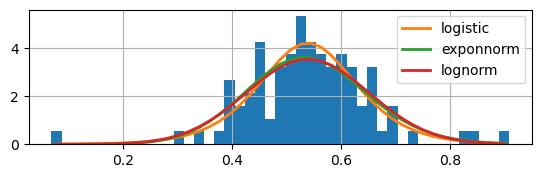

* Z-score method with sigma coeff. values: [3, 3] is 2 which amounts 2 %


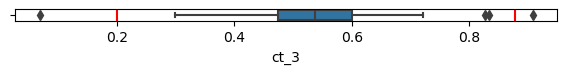

Outliers: [63, 188] 

*************************************SHALE*************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,712.041,-65.620,77.440,0.091,0.991
exponnorm,714.346,-68.615,80.500,0.094,0.987
norm,714.348,-70.616,77.504,0.094,0.987


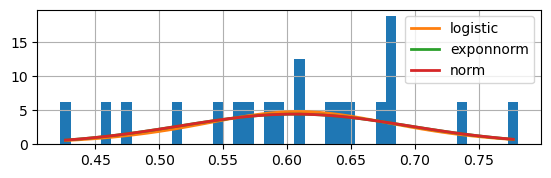

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.32860553474578474, 0.8829794004480667] 
 Observed values range: [0.42, 0.78] 

***********************************SANDSTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
norm,26.774,24.876,-108.965,0.075,0.632
exponnorm,26.774,26.876,-104.420,0.075,0.631
lognorm,26.846,27.013,-104.168,0.077,0.608


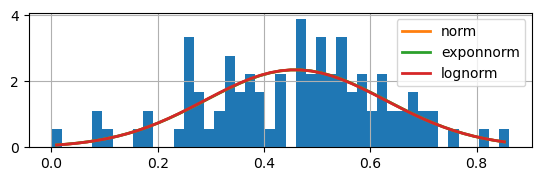

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [-0.05296233034812714, 0.97202953638956] 
 Observed values range: [0.0, 0.86] 

***********************************SILTSTOME***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,63.131,5.791,18.746,0.073,0.927
exponnorm,64.527,2.395,23.793,0.104,0.601
norm,64.527,0.394,19.862,0.104,0.601


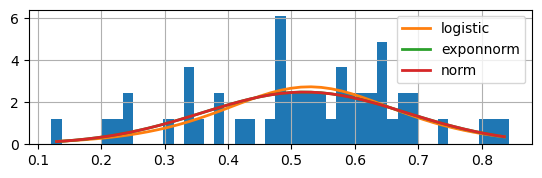

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.03407057675910563, 1.0064765203975337] 
 Observed values range: [0.12, 0.84] 

*********************************CLAY SANDSTONE********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
exponnorm,19.233,16.391,-409.637,0.037,0.955
lognorm,20.461,16.395,-398.056,0.035,0.967
gamma,21.336,15.804,-390.231,0.041,0.900


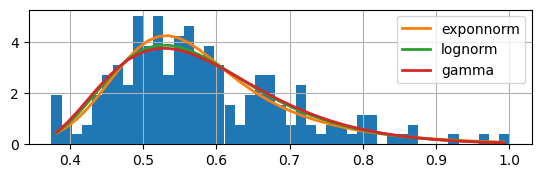

* Z-score method with sigma coeff. values: [3, 3] is 2 which amounts 1 %


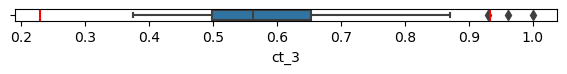

Outliers: [140, 281] 

Total number of outliers: 4
***********************************LIMESTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,62.526,58.097,-37.749,0.085,0.447
exponnorm,65.482,52.411,-28.525,0.086,0.426
lognorm,71.527,49.485,-19.694,0.105,0.207


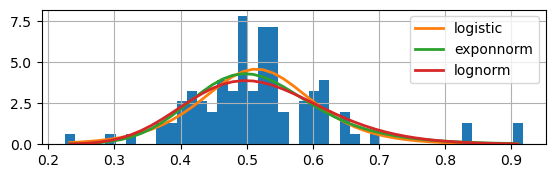

* Z-score method with sigma coeff. values: [3, 3] is 2 which amounts 2 %


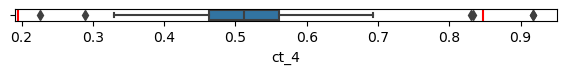

Outliers: [392, 401] 

*************************************SHALE*************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
uniform,789.367,-107.416,79.501,0.114,0.933
lognorm,816.437,-88.717,83.172,0.111,0.944
gamma,816.456,-88.887,83.172,0.111,0.943


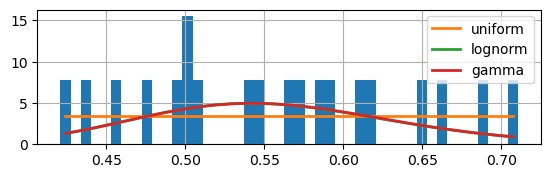

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.30593455167528927, 0.8082200061967765] 
 Observed values range: [0.42, 0.71] 

***********************************SANDSTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
lognorm,36.924,31.041,-74.207,0.048,0.977
exponnorm,36.932,30.612,-74.187,0.049,0.970
norm,36.932,28.612,-78.730,0.049,0.970


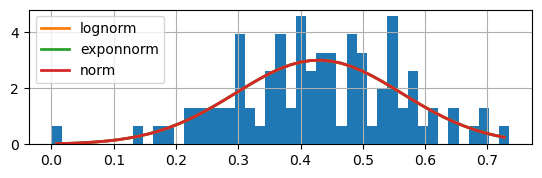

* Z-score method with sigma coeff. values: [3, 3] is 1 which amounts 1 %


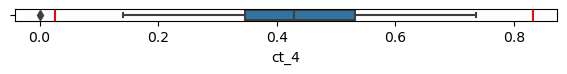

Outliers: [428] 

***********************************SILTSTOME***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
exponnorm,43.512,22.233,3.698,0.061,0.986
norm,43.512,20.233,-0.234,0.061,0.986
lognorm,43.594,22.072,3.794,0.062,0.984


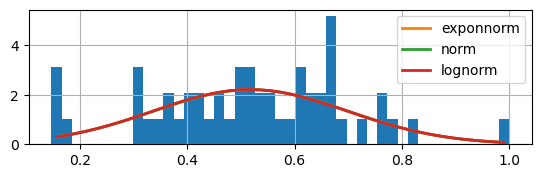

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [-0.030257913007620374, 1.0668278398098991] 
 Observed values range: [0.15, 1.0] 

*********************************CLAY SANDSTONE********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
exponnorm,18.059,56.993,-421.417,0.055,0.603
logistic,23.604,44.239,-376.566,0.075,0.226
lognorm,26.274,47.114,-351.297,0.086,0.121


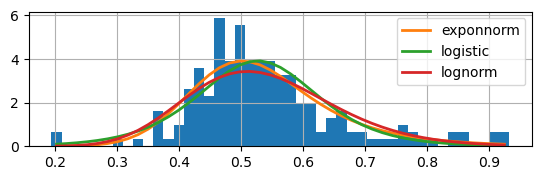

* Z-score method with sigma coeff. values: [3, 3] is 3 which amounts 2 %


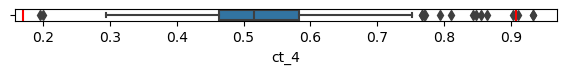

Outliers: [52, 133, 231] 

Total number of outliers: 6
***********************************LIMESTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
exponnorm,17.100,66.097,-162.792,0.045,0.982
logistic,20.278,70.458,-150.353,0.057,0.880
lognorm,20.935,70.339,-142.560,0.056,0.896


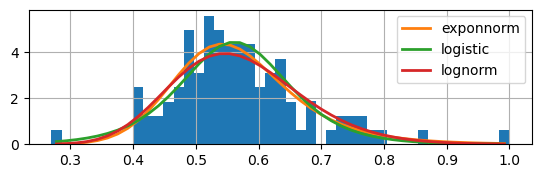

* Z-score method with sigma coeff. values: [3, 3] is 1 which amounts 1 %


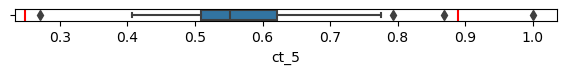

Outliers: [360] 

*************************************SHALE*************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,698.709,-47.097,77.061,0.090,0.992
exponnorm,708.428,-52.463,80.334,0.121,0.899
norm,708.433,-54.466,77.338,0.121,0.899


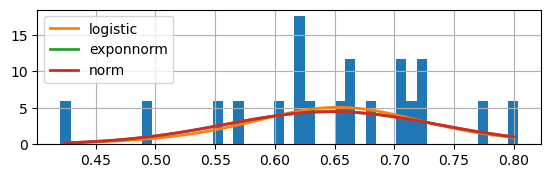

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.3731355864727157, 0.921188024755982] 
 Observed values range: [0.42, 0.8] 

***********************************SANDSTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,23.134,31.549,-122.702,0.051,0.960
norm,25.185,27.710,-114.716,0.075,0.643
exponnorm,25.185,29.708,-110.172,0.075,0.643


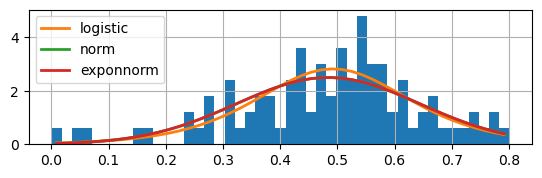

* Z-score method with sigma coeff. values: [3, 3] is 1 which amounts 1 %


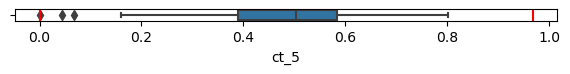

Outliers: [179] 

***********************************SILTSTOME***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
exponnorm,179.435,-30.956,75.953,0.068,0.961
norm,179.436,-32.956,72.021,0.068,0.961
lognorm,179.566,-30.863,75.990,0.067,0.964


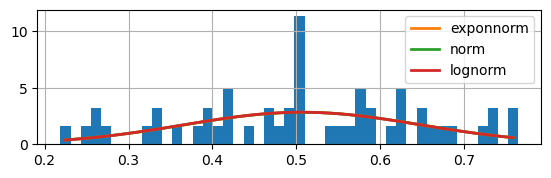

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.07899241058238415, 0.9357670457175943] 
 Observed values range: [0.22, 0.76] 

*********************************CLAY SANDSTONE********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
exponnorm,43.696,39.964,-256.178,0.091,0.084
logistic,51.020,23.010,-232.431,0.101,0.041
lognorm,55.409,28.892,-211.767,0.121,0.008


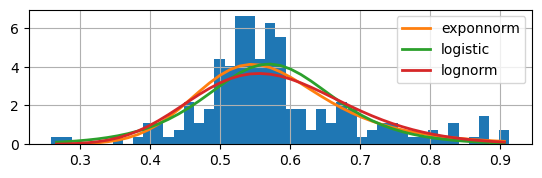

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.23772587002972795, 0.9229856626284132] 
 Observed values range: [0.26, 0.91] 

Total number of outliers: 2
***********************************LIMESTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
lognorm,76.214,-13.118,-13.347,0.084,0.450
norm,76.215,-15.209,-17.950,0.085,0.446
exponnorm,76.216,-13.205,-13.344,0.085,0.446


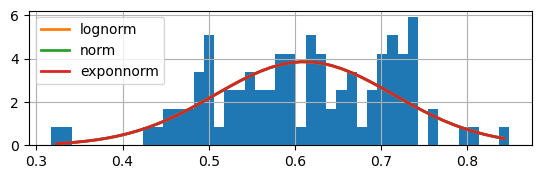

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.29949035997324314, 0.9224355933195306] 
 Observed values range: [0.32, 0.85] 

*************************************SHALE*************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
gamma,529.820,-54.004,74.523,0.098,0.980
lognorm,530.196,-53.845,74.537,0.099,0.978
exponnorm,536.997,-54.326,74.792,0.110,0.948


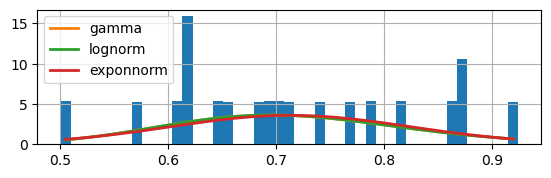

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.3711533924224622, 1.0567565033134358] 
 Observed values range: [0.5, 0.92] 

***********************************SANDSTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
norm,25.587,13.767,-113.227,0.073,0.673
exponnorm,25.588,15.765,-108.679,0.073,0.673
gamma,25.643,15.678,-108.477,0.073,0.668


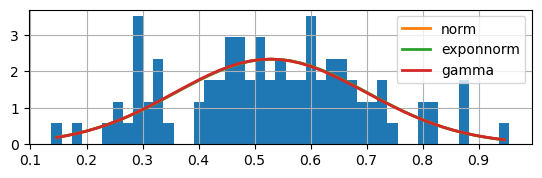

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.013979534146095762, 1.046149644699438] 
 Observed values range: [0.14, 0.95] 

***********************************SILTSTOME***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,38.194,40.462,-6.883,0.088,0.790
lognorm,41.983,32.696,1.873,0.140,0.245
exponnorm,42.181,32.169,2.112,0.143,0.223


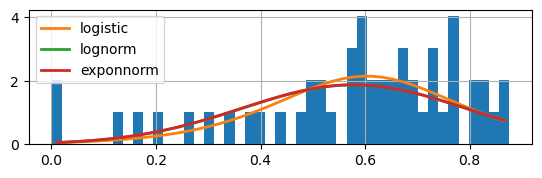

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [-0.06903429879987333, 1.2250707861673122] 
 Observed values range: [0.0, 0.88] 

*********************************CLAY SANDSTONE********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,48.189,29.919,-243.105,0.095,0.064
exponnorm,49.787,36.030,-231.775,0.096,0.062
lognorm,53.841,31.016,-217.134,0.109,0.021


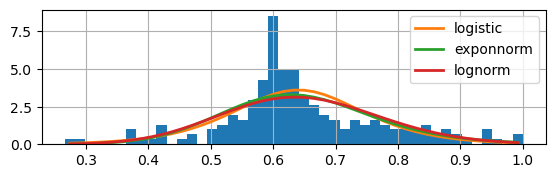

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.2615117360022318, 1.0320124618821487] 
 Observed values range: [0.27, 1.0] 

Total number of outliers: 0
***********************************LIMESTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,53.041,39.184,-54.200,0.049,0.961
norm,54.987,40.284,-50.597,0.067,0.728
exponnorm,54.987,42.283,-45.992,0.067,0.728


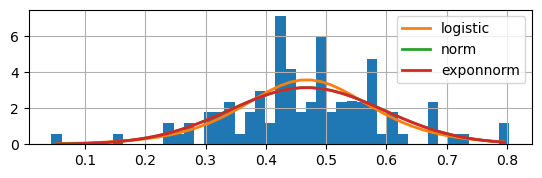

* Z-score method with sigma coeff. values: [3, 3] is 1 which amounts 1 %


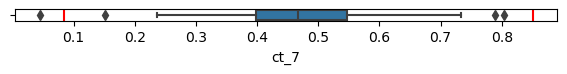

Outliers: [338] 

*************************************SHALE*************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
norm,456.699,-41.034,68.557,0.132,0.835
exponnorm,456.700,-39.032,71.553,0.132,0.835
lognorm,456.751,-38.771,71.555,0.132,0.831


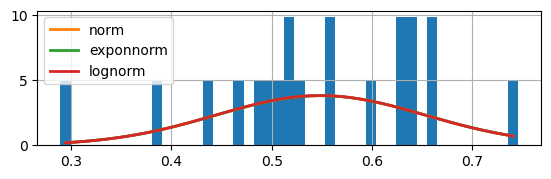

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [0.22660882958114215, 0.8711557101191465] 
 Observed values range: [0.29, 0.75] 

***********************************SANDSTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
norm,35.831,-2.353,-81.575,0.066,0.779
exponnorm,35.831,-0.351,-77.031,0.066,0.779
lognorm,35.956,-0.280,-76.703,0.066,0.775


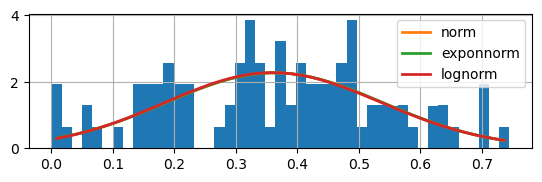

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [-0.16815124447142854, 0.8926789068981995] 
 Observed values range: [0.0, 0.74] 

***********************************SILTSTOME***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,60.333,4.642,16.435,0.069,0.952
exponnorm,60.706,1.617,20.681,0.072,0.939
norm,60.706,-0.383,16.749,0.072,0.939


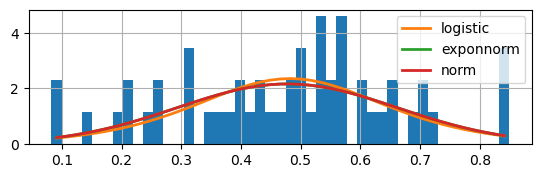

* Z-score method with sigma coeff. values: [3, 3] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by Sigma: [-0.0809956304461818, 1.0361788321857182] 
 Observed values range: [0.08, 0.85] 

*********************************CLAY SANDSTONE********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
exponnorm,25.389,55.806,-357.706,0.084,0.134
logistic,29.067,57.587,-337.637,0.096,0.061
lognorm,32.943,51.294,-308.998,0.109,0.022


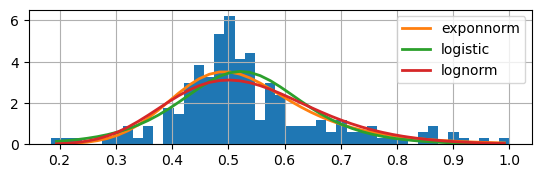

* Z-score method with sigma coeff. values: [3, 3] is 2 which amounts 1 %


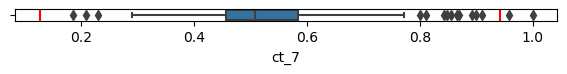

Outliers: [52, 85] 

Total number of outliers: 3
[[81, 152], [381, 150], [63, 188, 140, 281], [392, 401, 428, 52, 133, 231], [360, 179], [], [338, 52, 85]]


In [64]:
[*cts]=[distexaminer_lit(i, method="Sigma", verbose=3) for i in ['ct_'+str(k) for k in range(1, 8)]]
print(cts)

In [65]:
ct_ol=set(np.concatenate(cts[:-1]))

In [66]:
len(ct_ol)

16

As we can see from distribution shape fitting, the distributions are mostly of logistic or normal type, and we have 16 outliers. We are removing them 

In [67]:
data_train.drop(ct_ol, inplace=True)

In [68]:
# [*cts]=[distexaminer(data_train[i], method="IQR", Sigma_cf=[3, 3]) for i in ['ct_'+str(k) for k in range(1, 8)]]

Probably we can reduce CT number of dimensions by PCA?

The variance explained by 72.7 %


,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7
PCA_0,-0.31,-0.26,-0.30,-0.30,-0.34,-0.49,-0.55
PCA_1,-0.32,-0.26,0.39,-0.16,0.15,-0.54,0.58
PCA_2,0.33,-0.15,-0.69,0.34,-0.11,-0.31,0.42
PCA_3,0.64,-0.48,0.46,0.11,-0.32,-0.11,-0.16


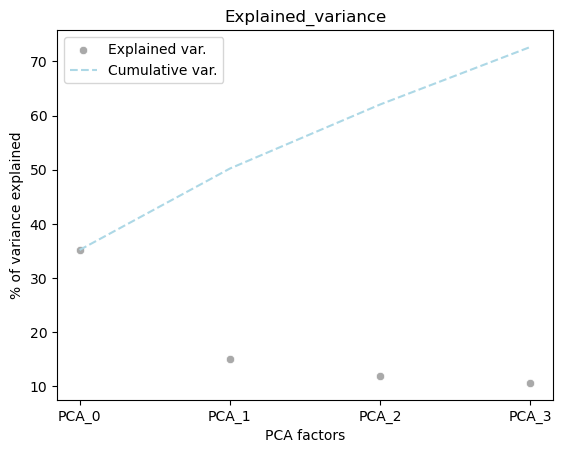

In [69]:
pca=PCA(4)
cts=data_train.filter(regex='ct_')
pca.fit(cts)

print('The variance explained by {} %'.format(round(100*pca.explained_variance_ratio_.sum(), 1)))

components=pd.DataFrame(pca.components_, index=['PCA_'+ str(i) for i in range(pca.components_.shape[0])] , columns=data_train.filter(regex='ct_').columns).round(2)
display(components)
sns.scatterplot(x=['PCA_'+ str(i) for i in range(pca.components_.shape[0])], 
                y=pca.explained_variance_ratio_*100, color='darkgrey', 
                label='Explained var.').set(title='Explained_variance', 
                                            xlabel='PCA factors', ylabel='% of variance explained')

plt.legend('PCA')
# ax.legend{'X'}
sns.lineplot(x=['PCA_'+ str(i) for i in range(pca.components_.shape[0])], y=np.cumsum(pca.explained_variance_ratio_)*100, legend=True, linestyle="dashed", color='lightblue', label='Cumulative var.').set(title='Explained_variance', xlabel='PCA factors', ylabel='% of variance explained')
plt.show()

As we can see, if we reduce the number of parameters we will  get no advantages so we'll keep them as they are.

Next step in ct values examination is a closer look at these values correlation to target values

We will also examine if we can improve correlations using:

    1) Particular ct feature share in sum of all ct values
    
    2) Max, Min and Mean values of ct group features as a independent feature
    

,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7
0,0.02,0.09,0.02,0.01,0.04,0.05,0.08


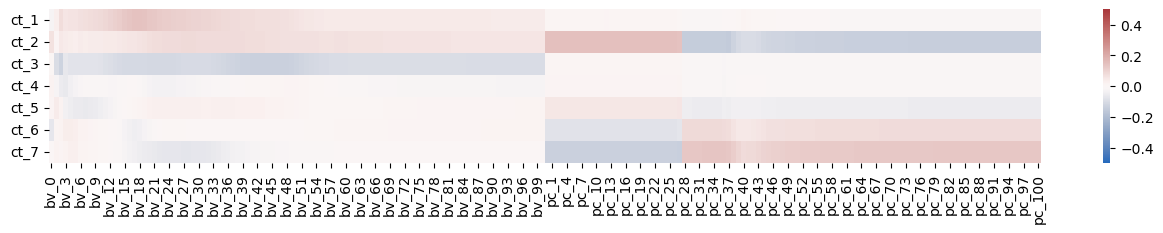

In [70]:
norm_ct=(data_train.filter(regex='ct_').T/(data_train.filter(regex='ct_').T.sum())).T
plt.figure(figsize=[16, 2])
ct_norm_trgtcorr=pd.DataFrame([norm_ct.corrwith(data_train[i]) for i in data_train.iloc[:, 16:-2].columns], index=data_train.iloc[:, 16:-2].columns).T
sns.heatmap(ct_norm_trgtcorr, vmin=-0.5, center=0, vmax=0.5, cmap='vlag')
display(ct_norm_trgtcorr.abs().median(1).round(2).to_frame().T)

And what about aggregate values?

,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7
0,0.12,0.09,0.13,0.12,0.1,0.17,0.16


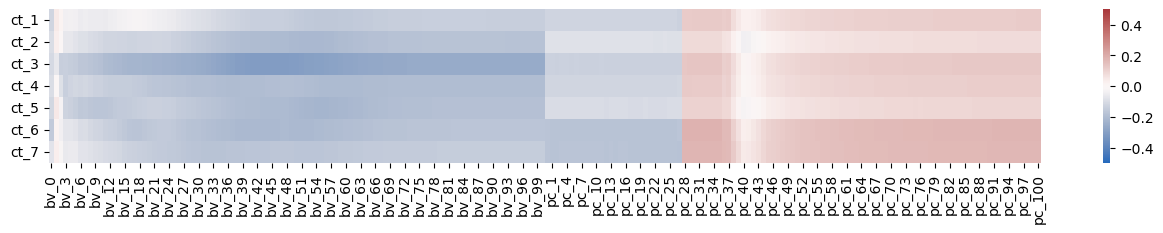

In [71]:
plt.figure(figsize=[16, 2])
ct_trgtcorr=pd.DataFrame([data_train.filter(regex='ct_').corrwith(data_train[i]) for i in data_train.iloc[:, 16:-2].columns], index=data_train.iloc[:, 16:-2].columns).T
sns.heatmap(ct_trgtcorr, vmin=-0.5, center=0, vmax=0.5, cmap='vlag')
display(ct_trgtcorr.abs().median(1).round(2).to_frame().T)

In [72]:
data_train['median_ct']=data_train.filter(regex='ct_').median(1)
data_test['median_ct']=data_test.filter(regex='ct_').median(1)

data_train['min_ct']=data_train.filter(regex='ct_').min(1)
data_test['min_ct']=data_test.filter(regex='ct_').min(1)

data_train['max_ct']=data_train.filter(regex='ct_').max(1)
data_test['max_ct']=data_test.filter(regex='ct_').max(1)

,mean_ct,max_ct,min_ct
0,0.21,0.24,0.06


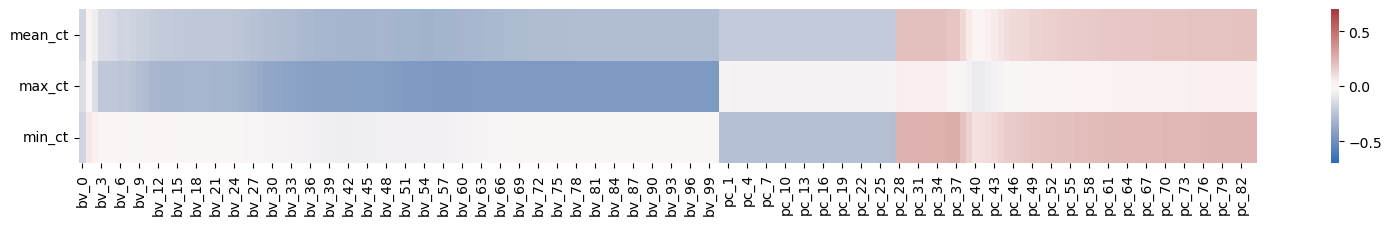

In [73]:
ct_agg_trgtcorr=pd.DataFrame([data_train.iloc[:, 16:-21].corrwith(data_train[i])for i in data_train[['median_ct', 'max_ct', 'min_ct']]], index=['mean_ct', 'max_ct', 'min_ct'])
plt.figure(figsize=[19, 2])
sns.heatmap(ct_agg_trgtcorr, vmin=-0.7, center=0, vmax=0.7, cmap='vlag')
display(ct_agg_trgtcorr.abs().median(1).round(2).to_frame().T)

As we can median ct is well correlated  with target value, but according our heatmap the dependence is fully related to bv values. Therefore we will look at bv and pc target values series separatewly

,mean_ct,max_ct,min_ct
0,0.28,0.44,0.02


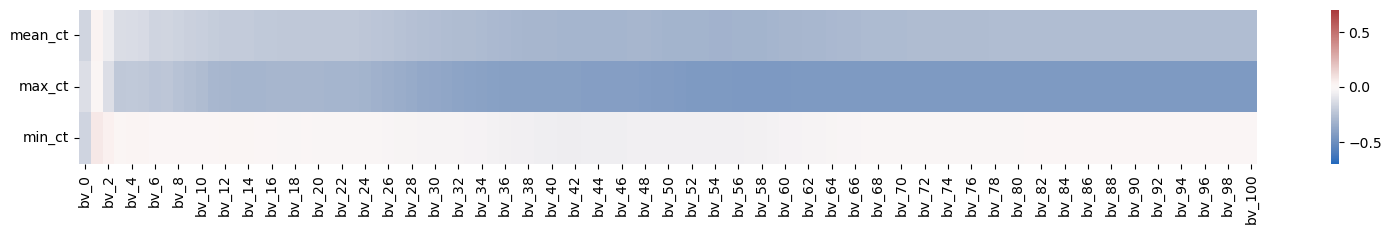

In [74]:
ct_agg_trgtcorr=pd.DataFrame([data_train.iloc[:, 16:117].corrwith(data_train[i])for i in data_train[['median_ct', 'max_ct', 'min_ct']]], index=['mean_ct', 'max_ct', 'min_ct'])
plt.figure(figsize=[19, 2])
sns.heatmap(ct_agg_trgtcorr, vmin=-0.7, center=0, vmax=0.7, cmap='vlag')
display(ct_agg_trgtcorr.abs().median(1).round(2).to_frame().T)

,mean_ct,max_ct,min_ct
0,0.2,0.04,0.24


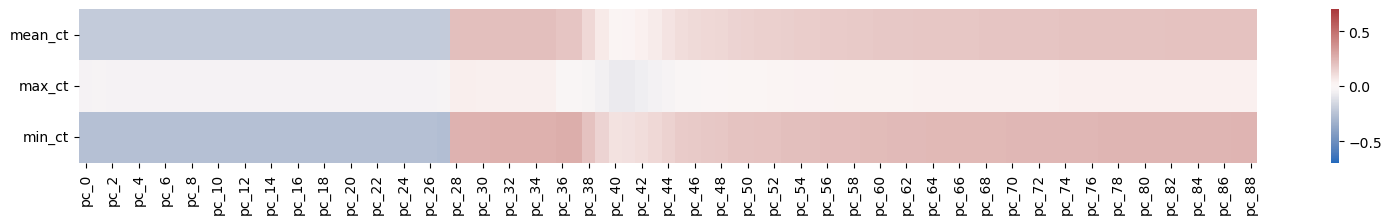

In [75]:
ct_agg_trgtcorr=pd.DataFrame([data_train.iloc[:, 117:-17].corrwith(data_train[i])for i in data_train[['median_ct', 'max_ct', 'min_ct']]], index=['mean_ct', 'max_ct', 'min_ct'])
plt.figure(figsize=[19, 2])
sns.heatmap(ct_agg_trgtcorr, vmin=-0.7, center=0, vmax=0.7, cmap='vlag')
display(ct_agg_trgtcorr.abs().median(1).round(2).to_frame().T)

In [76]:
data_train.filter(regex='ct_').corrwith(data_train['max_ct']).round(2).to_frame().T

,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7
0,0.21,0.56,0.29,0.37,0.33,0.51,0.31


#### $ ntg $

**************************************NTG**************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
exponnorm,9.170,14.063,-1665.476,0.069,0.031
norm,9.170,12.063,-1671.552,0.069,0.031
lognorm,9.294,14.183,-1659.624,0.071,0.023


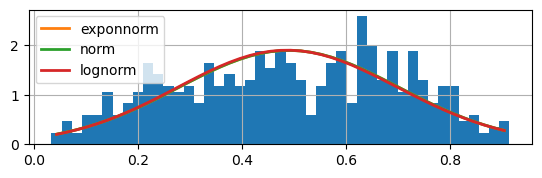

* IQR method with IQR coeff. values: [1.5, 1.5] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by IQR: [-0.17, 1.16] 
 Observed values range: [0.03, 0.91] 



In [77]:
distexaminer(data_train.ntg, method="IQR")

It looks like we have some outliers. Let's check if there are outliers when considering different lithologies 

***********************************LIMESTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
uniform,36.107,-23.430,-80.854,0.076,0.615
norm,46.681,-7.394,-56.709,0.115,0.153
exponnorm,46.681,-5.394,-52.165,0.115,0.153


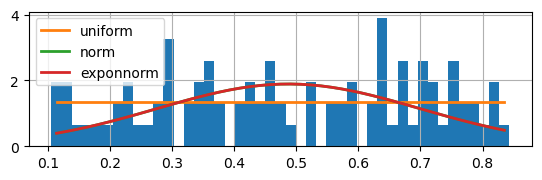

* IQR method with IQR coeff. values: [1.5, 1.5] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by IQR: [-0.25, 1.22] 
 Observed values range: [0.11, 0.84] 

*************************************SHALE*************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
uniform,249.759,-34.198,56.487,0.167,0.574
expon,269.239,-6.580,57.989,0.191,0.409
lognorm,272.324,-14.460,61.212,0.113,0.935


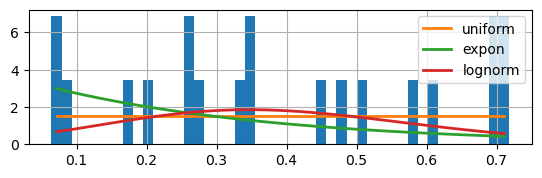

* IQR method with IQR coeff. values: [1.5, 1.5] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by IQR: [-0.28, 1.11] 
 Observed values range: [0.06, 0.72] 

***********************************SANDSTONE***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
uniform,47.768,-24.811,-49.628,0.100,0.298
norm,54.845,-7.815,-37.056,0.084,0.514
exponnorm,54.845,-5.815,-32.545,0.084,0.514


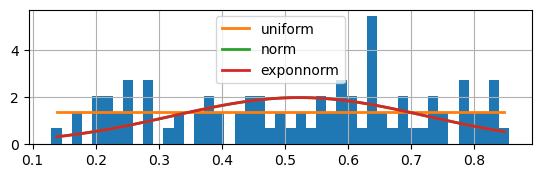

* IQR method with IQR coeff. values: [1.5, 1.5] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by IQR: [-0.11, 1.15] 
 Observed values range: [0.13, 0.86] 

***********************************SILTSTOME***********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,55.184,2.332,11.884,0.106,0.578
norm,56.162,-2.848,12.781,0.123,0.388
exponnorm,56.165,-0.848,16.715,0.123,0.387


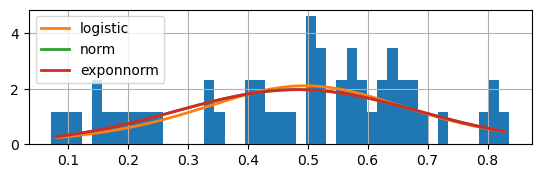

* IQR method with IQR coeff. values: [1.5, 1.5] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by IQR: [-0.07, 1.05] 
 Observed values range: [0.07, 0.84] 

*********************************CLAY SANDSTONE********************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
exponnorm,11.854,13.478,-474.068,0.064,0.425
norm,11.854,11.478,-479.261,0.064,0.425
gamma,11.857,13.490,-474.034,0.065,0.410


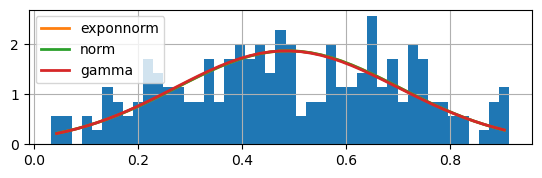

* IQR method with IQR coeff. values: [1.5, 1.5] is 0 which amounts 0 %
No outliers was found! 
 Acceptable values range by IQR: [-0.16, 1.15] 
 Observed values range: [0.03, 0.91] 

Total number of outliers: 0


[]

In [78]:
distexaminer_lit('ntg', 'IQR', verbose=2)

There are no outliers lithology-wise so the reason we have them for general set is co-existance of different rock types having their own distributions.

* #### $gr$

***************************************GR**************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,0.005,468.940,-4970.376,0.092,0.001
norm,0.007,469.126,-4785.532,0.128,0.000
exponnorm,0.007,471.125,-4779.452,0.128,0.000


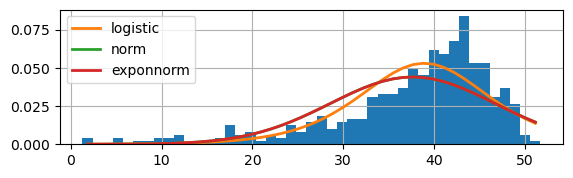

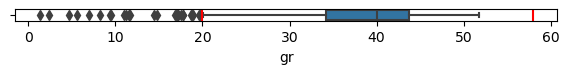

[8, 32, 39, 41, 49, 60, 76, 92, 97, 118, 119, 120, 135, 171, 174, 204, 227, 234, 263, 270, 271, 329, 362, 383, 396, 408, 429, 451]


In [79]:
print(distexaminer(data_train.gr, 'IQR', verbose=1))

For gr parameter we can see a non-Gaussian distribution again and there are a many outliers. We will try  to transform the distribution into more gaussian form by Box-Cox transformation.

In [80]:
pt=PowerTransformer(method='box-cox', standardize=True)
data_train['gr_pt']=pt.fit_transform(data_train[['gr']])
data_test['gr_pt']=pt.fit_transform(data_test[['gr']])

*************************************GR_PT*************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,0.273,167.235,-3203.911,0.056,0.124
norm,0.274,163.304,-3201.595,0.069,0.031
exponnorm,0.274,165.305,-3195.517,0.069,0.031


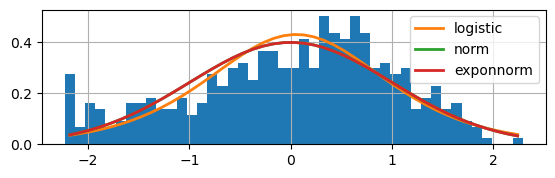

No outliers was found! 
 Acceptable values range by IQR: [-2.69, 2.76] 
 Observed values range: [-2.23, 2.29] 

None


In [81]:
print(distexaminer(data_train.gr_pt, 'IQR', verbose=0))

* #### $rhob$

Whole set distribution 

**************************************RHOB*************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
logistic,29.804,36.139,-1157.636,0.059,0.089
norm,31.010,48.834,-1140.332,0.077,0.011
exponnorm,31.011,50.834,-1134.253,0.077,0.011


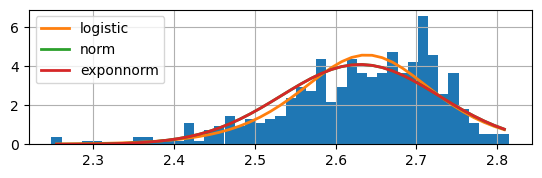

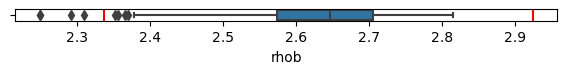

Whole set distribution outliers: 
 [89, 137, 323, 447] 



In [82]:
print('Whole set distribution', '\n')
print('Whole set distribution outliers:', '\n', distexaminer(data_train.rhob, 'Sigma', verbose=1), '\n')

The distribution is not normal so we look at lithologies

lithology ranges:
***********************************LIMESTONE***********************************


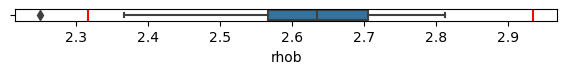

Outliers: [447] 

*************************************SHALE*************************************
No outliers was found! 
 Acceptable values range by Sigma: [2.3019593519917665, 2.917879445923817] 
 Observed values range: [2.42, 2.76] 

***********************************SANDSTONE***********************************


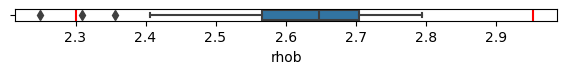

Outliers: [89] 

***********************************SILTSTOME***********************************


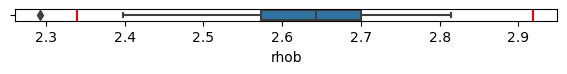

Outliers: [137] 

*********************************CLAY SANDSTONE********************************


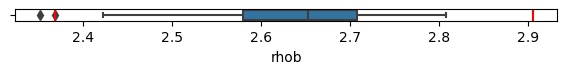

Outliers: [221] 

Total number of outliers: 4

 [447, 89, 137, 221] 



In [83]:
print('lithology ranges:')
print('\n', distexaminer_lit('rhob', 'Sigma', Nbest=5, verbose=1), '\n')

As we can see the non-gaussian nature of distribution is preseved over the lithologies. it means that we need transformation here. Let's use power transformer

************************************RHOB_PT************************************


,sumsquare_error,aic,bic,ks_statistic,ks_pvalue
exponnorm,0.241,186.742,-3251.400,0.050,0.212
norm,0.241,184.742,-3257.477,0.050,0.212
gamma,0.244,186.624,-3246.375,0.053,0.163


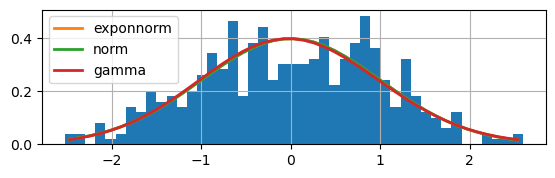

No outliers was found! 
 Acceptable values range by Sigma: [-3.003446296368958, 3.003446296368958] 
 Observed values range: [-2.52, 2.59] 

Whole set distribution outliers: 
 None 



In [84]:
pt=PowerTransformer(method='box-cox', standardize=True, copy=True)
data_train['rhob_pt']=pt.fit_transform(data_train[['rhob']])
print('Whole set distribution outliers:', '\n', distexaminer(data_train['rhob_pt'], 'Sigma', verbose=1), '\n')

* #### $ Lithology $

We have prepared all features based on quantitaive features and the only qualitative feature we haven't transformed is lithology. Now we will make the feature encoding by One Hot Encoder

In [85]:
ohe= OneHotEncoder(sparse=False)
lits=pd.DataFrame(ohe.fit_transform(data_train[["lithology"]]), columns=ohe.get_feature_names_out(), index=data_train.index)
lits
lits_test=pd.DataFrame(ohe.transform(data_test[["lithology"]]), columns=ohe.get_feature_names_out(), index=data_test.index)
data_train = pd.concat([data_train, lits],axis=1)
data_test = pd.concat([data_test, lits_test],axis=1)
lits_test

,lithology_clay sandstone,lithology_limestone,lithology_sandstone,lithology_shale,lithology_siltstome
0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
95,1.0,0.0,0.0,0.0,0.0
96,1.0,0.0,0.0,0.0,0.0
97,1.0,0.0,0.0,0.0,0.0
98,1.0,0.0,0.0,0.0,0.0


In [86]:
# lits=pd.DataFrame(ohe.fit_transform(data_train[["lithology"]]), columns=ohe.get_feature_names_out())
# lits.index=data_train.index
# data_train=pd.concat([data_train, lits], axis=1, join='inner')
# .drop(columns=["lithology"])

In [87]:
pt=PowerTransformer(method='box-cox', standardize=True, copy=True)
data_test['rhob_pt']=pt.fit_transform(data_test[['rhob']])

#### Lithology-wise sampling

We know that lithology type strongly predetermine its properties. That's why it is important to have balanced data, or, at least, to take it into account when predicting tatget  values for data set having diffferent lithoologies distribution

In [88]:
lit_split=pd.concat([data_train.lithology.value_counts(), data_test.lithology.value_counts()], axis=1) #lithology classes in the train/test dataset samples
lit_split.columns=['train', 'test']
lit_split.T

,clay sandstone,limestone,sandstone,siltstome,shale
train,180.0,94.0,91.0,51.0,20.0
test,73.0,9.0,3.0,15.0,NaN


In [89]:
#lithology classes in the deep/shallow strata train samples and in the test dataset samples
lit_split=pd.concat([data_train.groupby(data_train.depth>3000).lithology.value_counts().unstack().T, data_test.lithology.value_counts()], axis=1) 
lit_split.columns=['tr_shallow', 'tr-deep', 'test']
lit_split.T

,clay sandstone,limestone,sandstone,shale,siltstome
tr_shallow,150.0,94.0,35.0,NaN,12.0
tr-deep,30.0,NaN,56.0,20.0,39.0
test,73.0,9.0,3.0,NaN,15.0


In [90]:
# Lithology classes percentages
lit_split=lit_split.transform(lambda x:x/x.sum()).round(2)*100 
lit_split.columns=['% train shallow', '% train deep', '% in test']
lit_split

,% train shallow,% train deep,% in test
clay sandstone,52.0,21.0,73.0
limestone,32.0,NaN,9.0
sandstone,12.0,39.0,3.0
shale,NaN,14.0,NaN
siltstome,4.0,27.0,15.0


In [91]:
# lit_split=pd.concat([data_train.groupby(data_train.depth<3000).lithology.value_counts().unstack().T, data_test.lithology.value_counts()], axis=1)

ratio=lit_split.iloc[:,:2].sum(1)/lit_split.iloc[:, 2]
ratio.to_frame().T.round(2)

,clay sandstone,limestone,sandstone,shale,siltstome
0,1.0,3.56,17.0,NaN,2.07


In [92]:
# difference between the number of samples available and number of samples to add/remove from dataset to keep the same lithologies ratio as in test sample
split=data_train.shape[0]/data_test.shape[0]
fact_plan=pd.concat([lit_split.iloc[:,:2].sum(1), split*lit_split.iloc[:,:2].sum(1)/ratio], axis=1).drop('shale', axis=0).round(0)
fact_plan.columns=['Available', 'Required']
fact_plan['diff']=fact_plan.Available-fact_plan.Required.round(0)
pd.concat([fact_plan, fact_plan.sum().to_frame('Total').T], axis=0).T

,clay sandstone,limestone,sandstone,siltstome,Total
Available,73.0,32.0,51.0,31.0,187.0
Required,318.0,39.0,13.0,65.0,435.0
diff,-245.0,-7.0,38.0,-34.0,-248.0


As we can see if we want to keep relative amounts over both dataset we are missing 138 sandstone and 19 siltstone samples, and we have excessive number of sandstones and limestones.

We will try to use to competitive strategies:

1) upsampling/downsampling of lithologies in data_train set toi maintain lithologies ratio
2) Supposition that siltsone + sandstone portion of dataset samples features will be close in avearage to properties of clay sandstones.

In this notebook we will use 1st strategy

In [93]:
clay_sandstone, limestone, sandstone, shale, siltstone =[i[1] for i in data_train.groupby('lithology')]

In [94]:
def fact_plan(data, n_samples, random_state=42):
    return resample(data, random_state=random_state, n_samples=n_samples, replace=True)

In [95]:
fact_plan(data=limestone, n_samples=39, random_state=42)

,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,...,median_ct,min_ct,max_ct,gr_pt,rhob_pt,lithology_clay sandstone,lithology_limestone,lithology_sandstone,lithology_shale,lithology_siltstome
244,2047.343613,19.766370,2.703754,0.427230,0.701034,0.540628,0.581673,0.551690,0.585337,0.310852,...,0.551690,0.310852,0.701034,-0.041150,1.227139,0.0,1.0,0.0,0.0,0.0
451,2078.198020,19.385152,2.684518,0.382221,0.539792,0.513722,0.546612,0.533665,0.535784,0.609648,...,0.535784,0.382221,0.609648,-2.043519,-0.296800,0.0,1.0,0.0,0.0,0.0
88,1835.197181,4.414363,2.746476,0.513525,0.486119,0.568928,0.450596,0.550795,0.493785,0.427205,...,0.493785,0.427205,0.568928,-0.496153,2.536173,0.0,1.0,0.0,0.0,0.0
365,2106.735638,15.731020,2.692872,0.476347,0.664564,0.518508,0.498585,0.412310,0.690418,0.491655,...,0.498585,0.412310,0.690418,-0.324133,1.484086,0.0,1.0,0.0,0.0,0.0
280,2368.551417,10.917574,2.673706,0.434038,0.923886,0.431498,0.537450,0.523352,0.599374,0.319487,...,0.523352,0.319487,0.923886,-0.424395,-1.754192,0.0,1.0,0.0,0.0,0.0
100,2275.657134,13.068263,2.716939,0.495389,0.433893,0.542802,0.830522,0.515517,0.737901,0.312230,...,0.515517,0.312230,0.830522,-0.243114,-0.617418,0.0,1.0,0.0,0.0,0.0
413,2097.215562,20.347970,2.691781,0.478706,0.636823,0.409899,0.463881,0.554816,0.730924,0.425572,...,0.478706,0.409899,0.730924,-1.120667,2.302150,0.0,1.0,0.0,0.0,0.0
431,1825.232979,8.240656,2.740648,0.484001,0.549067,0.615850,0.609063,0.752990,0.683281,0.489026,...,0.609063,0.484001,0.752990,-0.226820,0.990848,0.0,1.0,0.0,0.0,0.0
388,2092.656268,10.686522,2.693521,0.417838,0.747193,0.457959,0.405922,0.611669,0.493151,0.448318,...,0.457959,0.405922,0.747193,-0.506781,0.834445,0.0,1.0,0.0,0.0,0.0
388,2092.656268,10.686522,2.693521,0.417838,0.747193,0.457959,0.405922,0.611669,0.493151,0.448318,...,0.457959,0.405922,0.747193,-0.506781,0.834445,0.0,1.0,0.0,0.0,0.0


In [96]:
# data_train.columns.get_loc('lithology')

As we can see lithologies distribution in train upper and lower strata differs from one of test sets. It means that for better results we need to keep relative amounts of lithologies in train sample equal to one of test sample.
But due to low number of train set samples, we will use  in this notebook whole dataset.

We are adding randomly sampled duplicates for siltstones (indexes 500-514) and clay sandstones (550-688).

In [97]:
# df_1 = df[df['store'] == 1]#set other classes to another dataframeother_df = df[df['store'] != 1]  #upsample the minority class
# df_1_upsampled = resample(df_1,random_state=42,n_samples=2,replace=True)#concatenate the upsampled dataframe
# df_upsampled = pd.concat([df_1_upsampled,other_df])
# df_upsampled

In [98]:
limestone=resample(limestone, random_state=42,n_samples=39,replace=True)
sandstone=resample(sandstone, random_state=42,n_samples=13,replace=True)


In [99]:
siltstone_ups=resample(siltstone, random_state=42,n_samples=14,replace=True)
siltstone_ups.index = pd.RangeIndex(start=500, stop=514, step=1)

In [100]:
claysandstones_ups=resample(clay_sandstone, random_state=42,n_samples=139,replace=True)
claysandstones_ups.index = pd.RangeIndex(start=550, stop=689, step=1)

In [101]:
data_train_bal=pd.concat([clay_sandstone, limestone, sandstone, shale, siltstone, claysandstones_ups, siltstone_ups])

In [102]:
data_train_bal=data_train_bal.query('lithology!="shale"')

In [103]:
data_train_bal

,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,...,median_ct,min_ct,max_ct,gr_pt,rhob_pt,lithology_clay sandstone,lithology_limestone,lithology_sandstone,lithology_shale,lithology_siltstome
5,3959.721012,12.059503,2.788302,0.656053,0.822468,0.629947,0.810411,0.640461,0.670880,0.601341,...,0.656053,0.601341,0.822468,-0.974374,-1.124545,1.0,0.0,0.0,0.0,0.0
11,2448.005924,27.066878,2.708096,0.559449,0.638617,0.487992,0.531703,0.564977,0.613538,0.551280,...,0.559449,0.487992,0.638617,-0.702032,0.841912,1.0,0.0,0.0,0.0,0.0
12,2425.756638,25.523742,2.694239,0.466495,0.676200,0.471522,0.573302,0.515393,0.604903,0.464511,...,0.515393,0.464511,0.676200,-0.235911,0.708185,1.0,0.0,0.0,0.0,0.0
13,2427.187451,28.598462,2.717578,0.584001,0.632832,0.539194,0.361427,0.536254,0.590448,0.534569,...,0.539194,0.361427,0.632832,-0.246554,0.275895,1.0,0.0,0.0,0.0,0.0
20,2447.168300,30.279174,2.680885,0.540420,0.605570,0.509210,0.469748,0.533393,0.676754,0.455523,...,0.533393,0.455523,0.676754,-0.328006,0.820827,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,3823.273366,0.668810,2.769647,0.574056,0.795637,0.507794,0.512952,0.400990,0.803890,0.842352,...,0.574056,0.400990,0.842352,0.567955,0.051083,0.0,0.0,0.0,0.0,1.0
510,3823.273366,0.668810,2.769647,0.574056,0.795637,0.507794,0.512952,0.400990,0.803890,0.842352,...,0.574056,0.400990,0.842352,0.567955,0.051083,0.0,0.0,0.0,0.0,1.0
511,3732.633851,9.511115,2.851477,0.369431,0.724073,0.530991,0.492751,0.727122,0.655350,0.499907,...,0.530991,0.369431,0.727122,0.679046,-0.749660,0.0,0.0,0.0,0.0,1.0
512,3628.430696,7.338994,2.810289,0.396883,0.516737,0.650474,0.318217,0.474293,0.608391,0.218542,...,0.474293,0.218542,0.650474,0.874036,1.008526,0.0,0.0,0.0,0.0,1.0


In [104]:
# data_train.loc[:,'ct_1':'ct_7']=mms.fit_transform(data_train.loc[:,'ct_1':'ct_7'])

The distribution well fitted, the feature will be transformed.

## 3) Target features

Let's plot pc and bv seies values

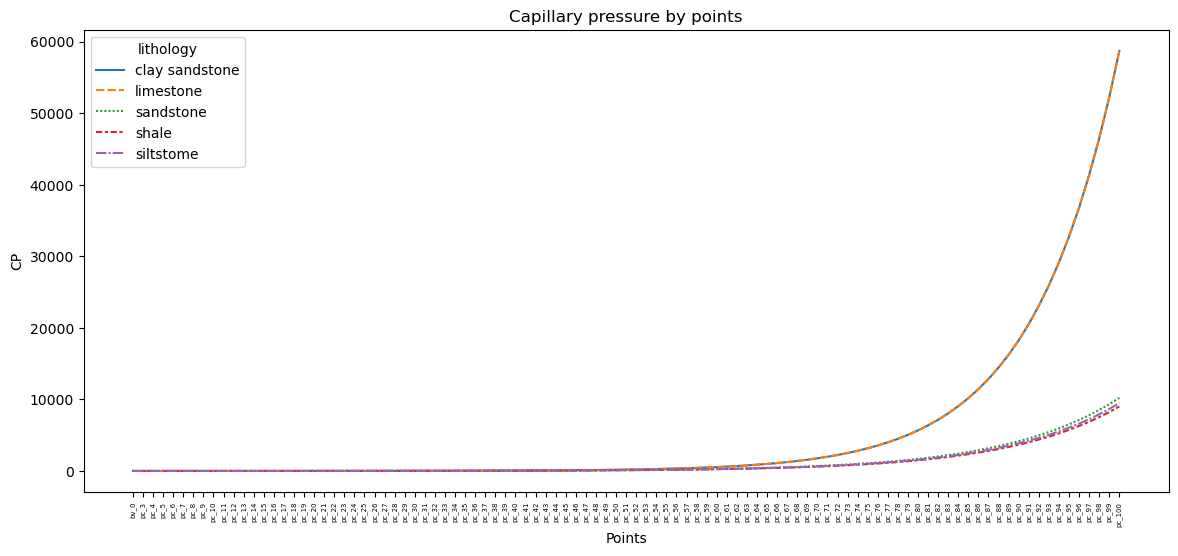

In [105]:
plt.figure(figsize=[14, 6])
litgroupmed_pc=(data_train.iloc[:, np.r_[13, 16, 120:218]].groupby(['lithology']).median().T)
sns.lineplot(litgroupmed_pc).set(xlabel='Points', ylabel='CP', title="Capillary pressure by points")
plt.xticks(rotation=90, size=5)
plt.show()

As we can see, the log transformation of cp values returns straight line, so we can use linear regression for transformed pc

As we can see, the log transformation of cp values returns straight line, so we can use linear regression for transformed pc

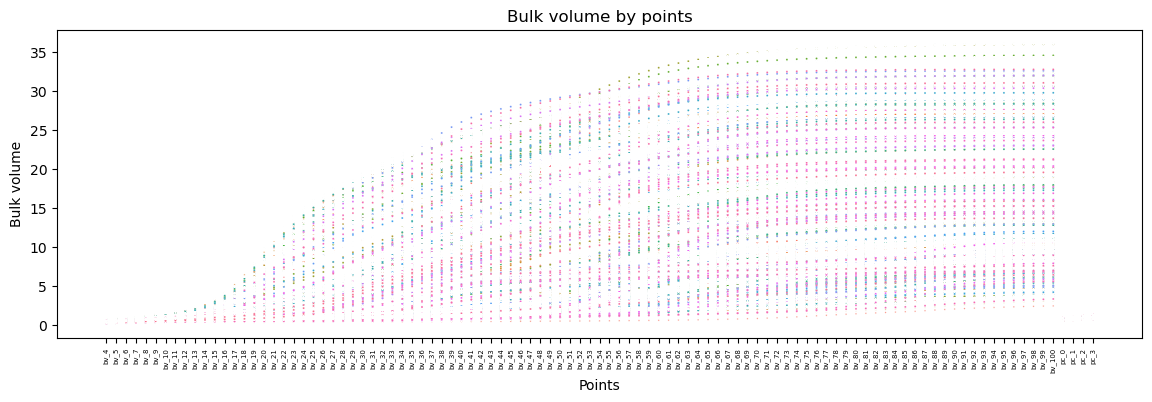

In [106]:
plt.figure(figsize=[14, 4])
cp_plot=sns.scatterplot((data_train.iloc[:, 20:121].T), legend=None, s=2)
cp_plot.set(xlabel='Points', ylabel='Bulk volume', title="Bulk volume by points")
plt.xticks(rotation=90, size=5)
plt.show()

Bulk volume trend is more complex, lithology-wise examination is required

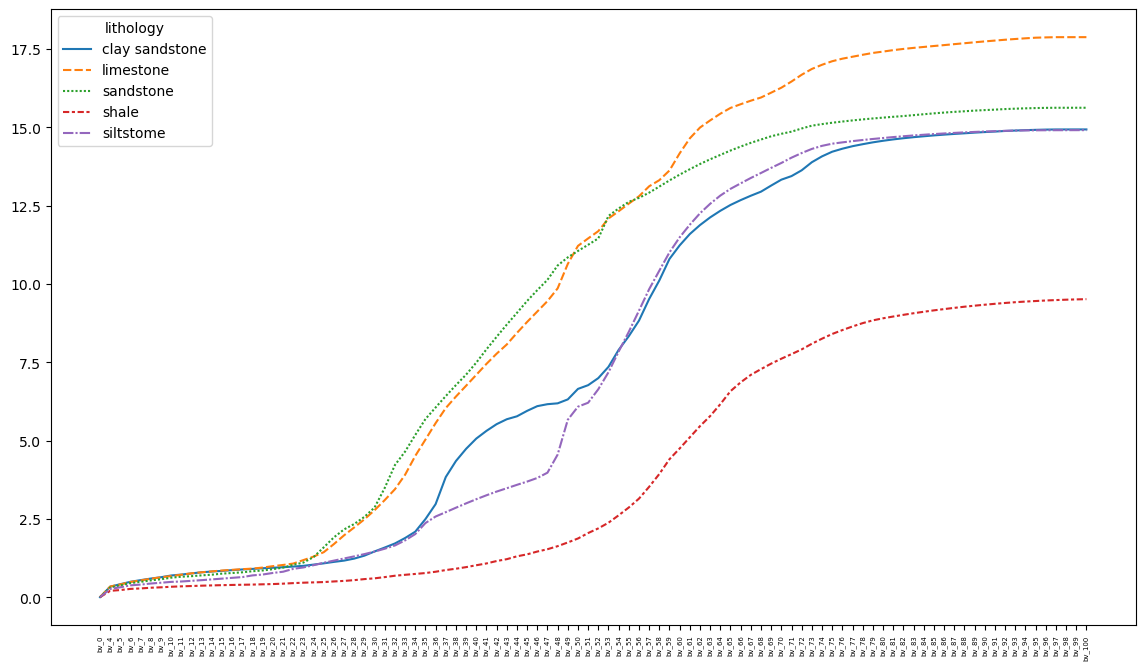

In [107]:
plt.figure(figsize=[14, 8])
litgroupmed_bv=(data_train.iloc[:, np.r_[13, 16, 20:117]].groupby(['lithology']).median().T)
sns.lineplot(litgroupmed_bv)
plt.xticks(rotation=90, size=5)
plt.show()

We see that each lithology has its own trajectory. Shale bulk volumne curve is the most distant from others as the most thick one.
Sandstone and shale bv median lines are quite smooth while for others lithologies the median lines have several fluctuations that indicate non-uniform pore size/admixtures distributions over the specific lithologies. 
The clay sandstone curve is between siltstone and sandstone lines and it is expected for siliclastic rocks of diffrent particle sizes.

We will try to built our models on:

    a) Unaltered train dataset
    
    b) On dataset with altered distributions (upsamling/downsampling)

### 4A) Target features examination standard dataset

We are starting with creation of a naive linear regression model that we'll use as a baseline for more sophisticated ones

In [108]:
Xl=data_train.drop(data_train.filter(regex='bv_|pc_').columns, axis=1)

In [109]:
X=Xl.drop('lithology', axis=1)
y_s=data_train.filter(regex='bv_|pc_')
X_test=data_test.loc[:, ~data_test.columns.str.contains('bv_|pc_')]
y_bv_s=data_train.filter(regex='bv')
y_pc_s=data_train.filter(regex='pc_')

Performance of model on whole train samples set will be checked by cross-validation 

In [110]:
reg=LinearRegression()
scores_bv = cross_val_score(reg, X, y_bv_s, cv=5).round(3)
scores_pc = cross_val_score(reg, X, y_pc_s, cv=5).round(3)
scores=cross_val_score(reg, X, y_s, cv=5).round(3)
display(pd.DataFrame([scores_bv.mean().round(3), scores_pc.mean().round(3), scores.mean().round(3)], index=['bv', 'cp', 'Overall'], columns=['R^2']).T)

,bv,cp,Overall
R^2,0.725,0.995,0.86


As we can see cp series value are perfectly fitted with such a simplistic model, while bv values are quite moderate. 

Next action we will take is estimation of features importances. We will use mean value of bv/pc points importances.

In [111]:
importances=pd.DataFrame([mir(X, y_s.loc[:, i], random_state=0) for i in y_s.columns.to_list()], index=y_s.columns, columns=X.columns)
bv_imp=importances.filter(regex='bv_', axis=0).mean().sort_values(ascending=False)
pc_imp=importances.filter(regex='pc_', axis=0).mean().sort_values(ascending=False)

In [112]:
bv_imp.nlargest(n=10).to_frame().T.round(2)
bv_imp

por                         1.557842
norm_depth                  0.462341
depth                       0.462269
den                         0.172778
max_ct                      0.129692
median_ct                   0.126145
bindepth                    0.126043
ct_6                        0.104928
ct_3                        0.100439
ct_2                        0.091780
min_ct                      0.085560
lithology_clay sandstone    0.081961
ct_7                        0.077705
ct_5                        0.074712
ct_1                        0.065554
lithology_limestone         0.059252
lithology_shale             0.051798
lithology_sandstone         0.039724
thickness_effective         0.038213
ct_4                        0.034389
gr                          0.028783
ntg                         0.026968
gr_pt                       0.023457
lithology_siltstome         0.010616
rhob                        0.007038
permeability                0.005594
rhob_pt                     0.003035
d

In [113]:
pc_imp.nlargest(n=10).to_frame().T.round(2)

,norm_depth,depth,bindepth,median_ct,lithology_clay sandstone,min_ct,den,lithology_limestone,lithology_sandstone,por
0,0.94,0.94,0.64,0.3,0.28,0.26,0.24,0.21,0.15,0.14


[Text(0.5, 1.0, 'pc_imp vs bv_imp'), Text(0.5, 0, 'bv'), Text(0, 0.5, 'pc')]

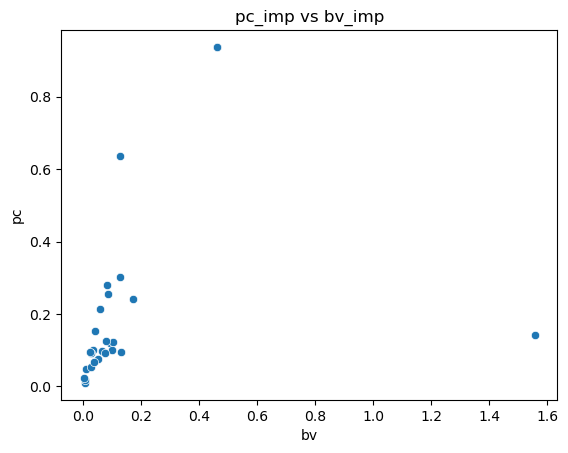

In [114]:
sns.scatterplot(x=bv_imp, y=pc_imp).set(title='pc_imp vs bv_imp', xlabel='bv', ylabel='pc')

In [115]:
Xl.drop('depth', axis=1, inplace=True)

As we know, lithology strongly affects target series features and our set imbalanced by the classes of this feature. 
Therefore we will use stratified sampling of records for train and validation sets. It probably makes sense to stratify by upper and lower layers also,
but in this notebook we will not do that.

In [116]:
x_train_s, x_val_s, y_train_s, y_val_s=train_test_split(Xl, y_s, stratify=Xl.lithology, random_state=42, train_size=0.75)

In [117]:
pd.concat([data_train.lithology.value_counts(), x_train_s.lithology.value_counts(), x_val_s.lithology.value_counts()], axis=1)

,lithology,lithology,lithology
clay sandstone,180,135,45
limestone,94,71,23
sandstone,91,68,23
siltstome,51,38,13
shale,20,15,5


In [118]:
x_train_s.drop('lithology', axis=1, inplace=True)
x_val_s.drop('lithology', axis=1, inplace=True)

To have a baseline we will built a naive model of linear regression for whole target values and for bv and pc series separately.

In [119]:
lr=LinearRegression()
lr.fit(x_train_s, y_train_s)
y_val_pred_s=lr.predict(x_val_s)
mse_val_s=mean_squared_error(y_val_pred_s, y_val_s, squared=False).round(2)
r2_val_s=r2_score(y_val_pred_s, y_val_s).round(3)
mape_s=mean_absolute_percentage_error(y_val_pred_s, y_val_s).round(2)*100
print(f'MSE for pc: {mse_val_s}, \n R^2:{r2_val_s}, \n MAPE:{mape_s}') 

MSE for pc: 14.35, 
 R^2:0.628, 
 MAPE:49.0


In [120]:
lr=LinearRegression()
lr.fit(x_train_s, y_train_s.filter(regex='pc_'))
y_val_pred_s=lr.predict(x_val_s)
mse_val_s=mean_squared_error(y_val_pred_s, y_val_s.filter(regex='pc_'), squared=False).round(2)
r2_val_s=r2_score(y_val_pred_s, y_val_s.filter(regex='pc_')).round(3)
mape_s=mean_absolute_percentage_error(y_val_pred_s, y_val_s.filter(regex='pc_')).round(2)*100
print(f'MSE for pc: {mse_val_s}, \n R^2:{r2_val_s}, \n MAPE:{mape_s}') 

MSE for pc: 26.5, 
 R^2:0.995, 
 MAPE:1.0


In [121]:
lr=LinearRegression()
lr.fit(x_train_s, y_train_s.filter(regex='bv_'))
y_val_pred_s=lr.predict(x_val_s)
mse_val_s=mean_squared_error(y_val_pred_s, y_val_s.filter(regex='bv_'), squared=False).round(2)
r2_val_s=r2_score(y_val_pred_s, y_val_s.filter(regex='bv_')).round(3)
mape_s=mean_absolute_percentage_error(y_val_pred_s, y_val_s.filter(regex='bv_')).round(2)*100
print(f'MSE for pc: {mse_val_s}, \n R^2:{r2_val_s}, \n MAPE:{mape_s}') 

MSE for pc: 2.21, 
 R^2:0.261, 
 MAPE:97.0


PC values are perfectly fitted so we will predict pc values right by the linear regression model. 
As long bv prediction model metrics are poor we will focus on them trying to fit models to original and synthetic data.

In [122]:
x_t, x_v = x_train_s, x_val_s
y_t, y_v = y_train_s.filter(regex='bv_'), y_val_s.filter(regex='bv_')

In [123]:
def bv_pc_modeller(x_t, x_v, y_t, y_v, model): #module for data fitting, prediction and metrics evaluation
    model.fit(x_t, y_t)
    y_pr_v=model.predict(x_v)
    mse_val=mean_squared_error(y_pr_v, y_v, squared=False).round(2)
    r2_val=r2_score(y_pr_v, y_v).round(3)
    mape=mean_absolute_percentage_error(y_pr_v, y_v).round(2)*100
    return mse_val, r2_val, mape
    

In [124]:
model_perf=dict() # search for best models
for i in [LinearRegression(),
          RandomForestRegressor(), 
          DecisionTreeRegressor(),
          BaggingRegressor(),
          # GradientBoostingRegressor(n_estimators=1000)),
          xgb(n_estimators=500), 
          MultiOutputRegressor(LGBMRegressor()), 
          MultiOutputRegressor(CatBoostRegressor(verbose=False)),
          MultiOutputRegressor(SVR()),
          # ElasticNet()
          KernelRidge(),
          # MultiOutputRegressor(SGDRegressor()),
          # GradientBoostingRegressor()
         ]:
          model_perf[str(i).strip('(|)')]=list(bv_pc_modeller(x_t, x_v, y_t, y_v, i))
         
model_perf=pd.DataFrame(model_perf, index=['MSE', 'R^2', 'MAPE']).T
model_perf

,MSE,R^2,MAPE
LinearRegression,2.21,2.610000e-01,97.0
RandomForestRegressor,1.63,6.580000e-01,24.0
DecisionTreeRegressor,2.13,6.710000e-01,46.0
BaggingRegressor,1.74,5.880000e-01,27.0
"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=500, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, ...",1.75,6.400000e-01,27.0
MultiOutputRegressor(estimator=LGBMRegressor,1.65,6.830000e-01,34.0
MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x0000021BC36E43A0>,1.70,6.140000e-01,23.0
MultiOutputRegressor(estimator=SVR,2.14,-1.542372e+29,34.0
KernelRidge,2.17,1.930000e-01,100.0


As we can see most of models with default hyperparameters settings are perform much better than linear model. 

## 4B) Target features examination synthetic dataset

We have compared performances of different models on original train dataset and now we will try to build models on bootstrapped train set having lithologies distribution similar to ones distribution in test set.

In [125]:
Xl=data_train_bal.drop(data_train_bal.filter(regex='bv_|pc_').columns, axis=1)

In [126]:
Xl.shape

(436, 28)

In [127]:
X=Xl.drop('lithology', axis=1)
y=data_train_bal.filter(regex='bv_|pc_')
X_test=data_test.loc[:, ~data_test.columns.str.contains('bv_|pc_')].drop(['lithology', 'depth'], axis=1)
y_bv=data_train_bal.filter(regex='bv')
y_pc=data_train_bal.filter(regex='pc_')

We will start with linear regressions for target values. Performance of model on whole train samples set will be checked by cross-validation 

In [128]:
reg=LinearRegression()
scores_bv = cross_val_score(reg, X, y_bv, cv=5).round(3)
scores_pc = cross_val_score(reg, X, y_pc, cv=5).round(3)
scores=cross_val_score(reg, X, y, cv=5).round(3)
display(pd.DataFrame([scores_bv.mean().round(3), scores_pc.mean().round(3), scores.mean().round(3)], index=['bv', 'cp', 'Overall'], columns=['R^2']).T)

,bv,cp,Overall
R^2,0.729,0.995,0.862


Next action we will take is estimation of features importances. We will use mean value of bv/pc points importances.

In [129]:
importances=pd.DataFrame([mir(X, y.loc[:, i], random_state=0) for i in y.columns.to_list()], index=y.columns, columns=X.columns)
bv_imp=importances.filter(regex='bv_', axis=0).mean().sort_values(ascending=False)
pc_imp=importances.filter(regex='pc_', axis=0).mean().sort_values(ascending=False)

In [130]:
bv_imp.nlargest(n=10).to_frame().T.round(2)

,por,norm_depth,depth,den,max_ct,ct_6,ct_3,ct_5,ct_2,median_ct
0,1.97,1.19,1.19,0.92,0.92,0.86,0.86,0.86,0.85,0.84


In [131]:
pc_imp.nlargest(n=10).to_frame().T.round(2)

,norm_depth,depth,median_ct,den,ct_5,por,min_ct,gr_pt,gr,ct_7
0,1.43,1.43,0.85,0.83,0.8,0.79,0.77,0.76,0.76,0.74


[Text(0.5, 1.0, 'pc_imp vs bv_imp'), Text(0.5, 0, 'bv'), Text(0, 0.5, 'pc')]

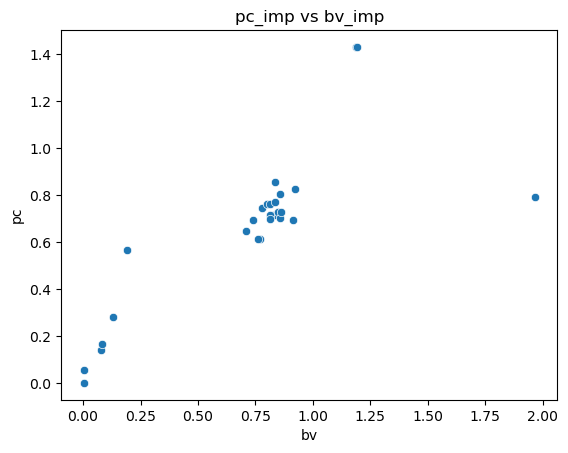

In [132]:
sns.scatterplot(x=bv_imp, y=pc_imp).set(title='pc_imp vs bv_imp', xlabel='bv', ylabel='pc')

In [133]:
X_top10_bv=data_train[['por', 'norm_depth', 'den', 'max_ct', 'median_ct', 'bindepth']]
X=X
reg=LinearRegression()
reg=RandomForestRegressor(random_state=42,max_depth=3, n_estimators=500)
scores_bv = cross_val_score(reg, X, y_bv, cv=5).round(3)
# scores_bv = cross_val_score(reg, X_top10_bv, y_bv, cv=5).round(3)
scores_bv.mean()

0.7744

As we know, lithology strongly affects target series features and our set imbalanced by the classes of this feature. 
Therefore we will use stratified sampling of records for train and validation sets. It probably makes sense to stratify by upper and lower layers also,
but in this notebook we will not do that.

In [134]:
x_train, x_val, y_train, y_val=train_test_split(Xl, y, stratify=Xl.lithology, random_state=42, train_size=0.75)

In [135]:
x_test=data_test.drop(['lithology', 'depth'], axis=1)

In [136]:
pd.concat([data_train.lithology.value_counts(), x_train.lithology.value_counts(), x_val.lithology.value_counts()], axis=1)

,lithology,lithology,lithology
clay sandstone,180,239.0,80.0
limestone,94,29.0,10.0
sandstone,91,10.0,3.0
siltstome,51,49.0,16.0
shale,20,NaN,NaN


In [137]:
x_train.drop('lithology', axis=1, inplace=True)
x_val.drop('lithology', axis=1, inplace=True)

To have a baseline we will built a naive model of linear regression for whole target values and for bv and pc series separately.

In [138]:
lr=LinearRegression()
lr.fit(x_train, y_train)
y_val_pred=lr.predict(x_val)
mse_val=mean_squared_error(y_val_pred, y_val, squared=False).round(3)
r2_val=r2_score(y_val_pred, y_val).round(3)
mape=(mean_absolute_percentage_error(y_val_pred, y_val)*100).round(3)
print(f'MSE for whole target series: {mse_val}, \n R^2:{r2_val}, \n MAPE:{mape}') 

MSE for whole target series: 12.271, 
 R^2:0.724, 
 MAPE:87.239


In [139]:
lr=LinearRegression()
lr.fit(x_train, y_train.filter(regex='pc_'))
y_val_pred=lr.predict(x_val)
mse_val=mean_squared_error(y_val_pred, y_val.filter(regex='pc_'), squared=False).round(2)
r2_val=r2_score(y_val_pred, y_val.filter(regex='pc_')).round(3)
mape=mean_absolute_percentage_error(y_val_pred, y_val.filter(regex='pc_')).round(2)*100
print(f'MSE for pc: {mse_val}, \n R^2:{r2_val}, \n MAPE:{mape}') 

MSE for pc: 22.61, 
 R^2:0.996, 
 MAPE:1.0


In [140]:
lr=LinearRegression()
lr.fit(x_train, y_train.filter(regex='bv_'))
y_val_pred=lr.predict(x_val)
mse_val=mean_squared_error(y_val_pred, y_val.filter(regex='bv_'), squared=False).round(2)
r2_val=r2_score(y_val_pred, y_val.filter(regex='bv_')).round(3)
mape=mean_absolute_percentage_error(y_val_pred, y_val.filter(regex='bv_')).round(2)*100
print(f'MSE for bv: {mse_val}, \n R^2:{r2_val}, \n MAPE:{mape}') 

MSE for bv: 1.94, 
 R^2:0.452, 
 MAPE:174.0


In [141]:
x_train.columns

Index(['depth', 'por', 'den', 'ct_1', 'ct_2', 'ct_3', 'ct_4', 'ct_5', 'ct_6',
       'ct_7', 'permeability', 'ntg', 'thickness_effective', 'gr', 'rhob',
       'bindepth', 'norm_depth', 'median_ct', 'min_ct', 'max_ct', 'gr_pt',
       'rhob_pt', 'lithology_clay sandstone', 'lithology_limestone',
       'lithology_sandstone', 'lithology_shale', 'lithology_siltstome'],
      dtype='object')

In [142]:
x_test.columns

Index(['por', 'den', 'ct_1', 'ct_2', 'ct_3', 'ct_4', 'ct_5', 'ct_6', 'ct_7',
       'permeability', 'ntg', 'thickness_effective', 'gr', 'rhob',
       'norm_depth', 'bindepth', 'median_ct', 'min_ct', 'max_ct', 'gr_pt',
       'lithology_clay sandstone', 'lithology_limestone',
       'lithology_sandstone', 'lithology_shale', 'lithology_siltstome',
       'rhob_pt'],
      dtype='object')

In [143]:
y_val.filter(regex='pc_')

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
88,0.534381,0.594595,0.664265,0.744806,0.834441,0.931825,1.038232,1.157299,1.293409,1.448820,...,20520.933989,23074.023530,25926.289756,29134.546094,32743.355361,36788.622187,41342.153887,46450.386367,52204.749443,58641.102607
577,0.514362,0.570604,0.646223,0.723757,0.811823,0.913043,1.021074,1.143074,1.279460,1.432670,...,20521.116885,23075.517374,25935.469961,29149.456762,32759.225051,36808.816063,41347.114234,46464.585920,52223.879825,58686.136971
76,0.908223,1.038261,1.168147,1.298215,1.437410,1.557433,1.813745,1.965545,2.168220,2.359182,...,4184.678529,4571.135007,4995.368782,5466.462514,5985.763891,6547.988805,7159.873587,7838.186991,8573.485532,9383.231689
53,0.521733,0.578571,0.650068,0.731831,0.821168,0.921083,1.027927,1.148240,1.285693,1.440577,...,20524.549223,23076.920825,25937.524615,29150.407307,32754.216479,36798.174722,41350.205717,46474.807520,52236.897543,58698.071879
51,0.523805,0.582588,0.652856,0.733774,0.823535,0.920607,1.029465,1.149408,1.286776,1.442640,...,20521.409200,23075.376232,25932.789906,29140.025309,32737.289533,36778.173691,41339.766271,46471.316310,52221.358306,58678.018977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0.524621,0.583101,0.653966,0.734575,0.824159,0.922676,1.029667,1.148162,1.286242,1.441618,...,20517.041266,23071.410288,25925.281793,29137.440375,32740.350393,36784.384117,41335.007610,46452.951443,52202.757653,58647.185613
560,0.523131,0.582724,0.652492,0.733139,0.822613,0.919174,1.027919,1.148696,1.285082,1.440867,...,20519.218595,23074.266828,25929.401595,29131.810543,32731.342082,36774.532656,41335.139689,46466.878986,52215.336158,58671.851477
652,0.524862,0.584234,0.654591,0.735395,0.824854,0.921846,1.029282,1.147917,1.285593,1.441259,...,20513.445558,23070.773920,25920.090914,29130.093006,32729.419334,36772.465017,41328.383283,46447.684563,52192.163545,58631.705077
136,0.531291,0.591272,0.662598,0.740824,0.830725,0.928156,1.034877,1.154014,1.289689,1.445116,...,20517.389510,23071.830459,25921.781724,29132.436466,32742.940287,36783.119450,41337.870715,46442.207603,52189.936899,58622.408100


In [144]:
lr=LinearRegression()
lr.fit(x_train, y_train.filter(regex='pc_'))
y_val_pred=lr.predict(x_val)
mse_val=mean_squared_error(y_val_pred, y_val.filter(regex='pc_'), squared=False).round(2)
r2_val=r2_score(y_val_pred, y_val.filter(regex='pc_')).round(3)
mape=mean_absolute_percentage_error(y_val_pred, y_val.filter(regex='pc_')).round(2)*100
print(f'MSE for pc: {mse_val}, \n R^2:{r2_val}, \n MAPE:{mape}') 

MSE for pc: 22.61, 
 R^2:0.996, 
 MAPE:1.0


PC values are perfectly fitted so we need to focus on extremely underfitted model for BV.
We will check different kind of models trying to improve model prediction 

In [145]:
x_t, x_v = x_train, x_val 
y_t, y_v = y_train.filter(regex='bv_'), y_val.filter(regex='bv_')

In [146]:
def bv_pc_modeller(x_t, x_v, y_t, y_v, model): #module for data fitting, prediction and metrics evaluation
    model.fit(x_t, y_t)
    y_pr_v=model.predict(x_v)
    mse_val=mean_squared_error(y_pr_v, y_v, squared=False).round(2)
    r2_val=r2_score(y_pr_v, y_v).round(3)
    mape=mean_absolute_percentage_error(y_pr_v, y_v).round(2)*100
    return mse_val, r2_val, mape
    

In [147]:
model_perf=dict() # search for best models
for i in [LinearRegression(),
          RandomForestRegressor(), 
          DecisionTreeRegressor(),
          BaggingRegressor(),
          MultiOutputRegressor(GradientBoostingRegressor(n_estimators=1000)),
          xgb(n_estimators=500), 
          MultiOutputRegressor(LGBMRegressor()), 
          MultiOutputRegressor(CatBoostRegressor(verbose=False)),
          MultiOutputRegressor(SVR()),
          # ElasticNet()
          KernelRidge(),
          MultiOutputRegressor(SGDRegressor())
         ]:
    model_perf[str(i).strip('(|)')]=list(bv_pc_modeller(x_t, x_v, y_t, y_v, i))
        
    # , , GradientBoostingRegressor(), 
model_perf=pd.DataFrame(model_perf, index=['MSE', 'R^2', 'MAPE']).T
model_perf

# from sklearn.linear_model import SGDRegressor
          # from sklearn.svm import SVR
# 

,MSE,R^2,MAPE
LinearRegression,1.940000e+00,4.520000e-01,174.0
RandomForestRegressor,9.200000e-01,9.450000e-01,14.0
DecisionTreeRegressor,1.320000e+00,9.320000e-01,13.0
BaggingRegressor,1.040000e+00,9.210000e-01,14.0
MultiOutputRegressor(estimator=GradientBoostingRegressor(n_estimators=1000,9.300000e-01,-8.092402e+27,10.0
"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=500, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, ...",8.300000e-01,9.520000e-01,8.0
MultiOutputRegressor(estimator=LGBMRegressor,8.100000e-01,9.530000e-01,13.0
MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x0000021BC47FBE80>,8.600000e-01,9.620000e-01,9.0
MultiOutputRegressor(estimator=SVR,7.080000e+00,-1.815665e+03,82.0
KernelRidge,1.920000e+00,3.410000e-01,124.0


The results we received looks to good to be true, most probably we have a overfitting, or probably we have a leak from train to validation set. 
To check what will we have on non-altered data, we will try to predict target values from original dataset.

In [148]:
x_t.columns

Index(['depth', 'por', 'den', 'ct_1', 'ct_2', 'ct_3', 'ct_4', 'ct_5', 'ct_6',
       'ct_7', 'permeability', 'ntg', 'thickness_effective', 'gr', 'rhob',
       'bindepth', 'norm_depth', 'median_ct', 'min_ct', 'max_ct', 'gr_pt',
       'rhob_pt', 'lithology_clay sandstone', 'lithology_limestone',
       'lithology_sandstone', 'lithology_shale', 'lithology_siltstome'],
      dtype='object')

In [149]:
x_t.drop(['depth'], axis=1, inplace=True)

In [150]:
x_t, x_v = x_train, x_val_s 
y_t, y_v = y_train.filter(regex='bv_'), y_val_s.filter(regex='bv_')

In [151]:
def bv_pc_modeller(x_t, x_v, y_t, y_v, model): #module for data fitting, prediction and metrics evaluation
    model.fit(x_t, y_t)
    y_pr_v=model.predict(x_v)
    mse_val=mean_squared_error(y_pr_v, y_v, squared=False).round(2)
    r2_val=r2_score(y_pr_v, y_v).round(3)
    mape=mean_absolute_percentage_error(y_pr_v, y_v).round(2)*100
    return mse_val, r2_val, mape
    

In [152]:
x_v=x_v[['por', 'den', 'ct_1', 'ct_2', 'ct_3', 'ct_4', 'ct_5', 'ct_6', 'ct_7', 'permeability', 'ntg', 'thickness_effective', 'gr', 'rhob','bindepth', 'norm_depth',  'median_ct', 'min_ct', 'max_ct', 'gr_pt', 'rhob_pt', 'lithology_clay sandstone', 'lithology_limestone', 'lithology_sandstone', 'lithology_shale', 'lithology_siltstome']]

In [153]:

# ValueError: feature_names mismatch: 
#     ['por', 'den', 'ct_1', 'ct_2', 'ct_3', 'ct_4', 'ct_5', 'ct_6', 'ct_7', 'permeability', 'ntg', 'thickness_effective', 'gr', 'rhob', 'norm_depth', 'bindepth', 'median_ct', 'min_ct', 'max_ct', 'gr_pt', 'rhob_pt', 'lithology_clay sandstone', 'lithology_limestone', 'lithology_sandstone', 'lithology_shale', 'lithology_siltstome']
#     ['por', 'den', 'ct_1', 'ct_2', 'ct_3', 'ct_4', 'ct_5', 'ct_6', 'ct_7', 'permeability', 'ntg', 'thickness_effective', 'gr', 'rhob', 'bindepth', 'norm_depth', 'median_ct', 'min_ct', 'max_ct', 'gr_pt', 'rhob_pt', 'lithology_clay sandstone', 'lithology_limestone', 'lithology_sandstone', 'lithology_shale', 'lithology_siltstome']

In [154]:
model_perf=dict() # search for best models
for i in [LinearRegression(),
          RandomForestRegressor(), 
          DecisionTreeRegressor(),
          BaggingRegressor(),
          # GradientBoostingRegressor(n_estimators=1000)),
          xgb(n_estimators=500), 
          MultiOutputRegressor(LGBMRegressor()), 
          MultiOutputRegressor(CatBoostRegressor(verbose=False)),
          MultiOutputRegressor(SVR()),
          # ElasticNet()


          KernelRidge(),
          # MultiOutputRegressor(SGDRegressor())

         ]:
    model_perf[str(i).strip('(|)')]=list(bv_pc_modeller(x_t, x_v, y_t, y_v, i))
        
    # , , GradientBoostingRegressor(), 
model_perf=pd.DataFrame(model_perf, index=['MSE', 'R^2', 'MAPE']).T
model_perf

# from sklearn.linear_model import SGDRegressor
          # from sklearn.svm import SVR
# 

,MSE,R^2,MAPE
LinearRegression,2.11,0.417,166.0
RandomForestRegressor,1.06,0.907,14.0
DecisionTreeRegressor,1.58,0.884,17.0
BaggingRegressor,1.24,0.883,16.0
"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=500, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, ...",1.13,0.912,11.0
MultiOutputRegressor(estimator=LGBMRegressor,1.07,0.909,16.0
MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x0000021BC498A640>,1.22,0.913,11.0
MultiOutputRegressor(estimator=SVR,2.10,-3.239,32.0
KernelRidge,2.10,0.343,193.0


As we can see, the models work surprisingly well! We will use  model for prediction of bv series values. As long as we know that test samples features values are very different from the features we have for upper and lower strata of train dataset. 
It means that if we will tune hyperparameters of our models for data in train set, we will have poor results on test dataset. So we will not tune them. Best performance models are catboost and XGBoost regressors. As XGB has lower MSE, we will use this model.

In [155]:
# X_test.drop(['lithology', 'depth'], axis=1, inplace=True)

## 5) Predictions of BV and PC for test set

Prediction of bulk volumes:

In [164]:
x_t=x_t[['por', 'den', 'ct_1', 'ct_2', 'ct_3', 'ct_4', 'ct_5', 'ct_6', 'ct_7', 'permeability', 'ntg', 'thickness_effective', 'gr', 'rhob', 'norm_depth', 'bindepth',   'median_ct', 
 'min_ct', 'max_ct', 'gr_pt', 'lithology_clay sandstone', 'lithology_limestone', 'lithology_sandstone', 'lithology_shale', 'lithology_siltstome', 'rhob_pt']]

In [165]:
X_test.columns

Index(['por', 'den', 'ct_1', 'ct_2', 'ct_3', 'ct_4', 'ct_5', 'ct_6', 'ct_7',
       'permeability', 'ntg', 'thickness_effective', 'gr', 'rhob',
       'norm_depth', 'bindepth', 'median_ct', 'min_ct', 'max_ct', 'gr_pt',
       'lithology_clay sandstone', 'lithology_limestone',
       'lithology_sandstone', 'lithology_shale', 'lithology_siltstome',
       'rhob_pt'],
      dtype='object')

In [166]:
reg=xgb(random_state=42)
reg.fit(x_t, y_t)
y_bv_pred=pd.DataFrame(reg.predict(X_test), columns=['bv_'+str(i) for i in range(101)])
y_bv_pred

,bv_0,bv_1,bv_2,bv_3,bv_4,bv_5,bv_6,bv_7,bv_8,bv_9,...,bv_91,bv_92,bv_93,bv_94,bv_95,bv_96,bv_97,bv_98,bv_99,bv_100
0,1.842817e-16,0.053788,0.137032,0.327604,0.387636,0.434505,0.520784,0.593776,0.575919,0.641221,...,18.702829,18.909426,18.943716,18.929384,19.049906,19.103951,19.156052,19.137363,19.170546,19.176199
1,1.842817e-16,0.056022,0.125141,0.286285,0.336045,0.332974,0.372442,0.441997,0.474016,0.520174,...,15.334660,15.637970,15.439658,14.728227,14.555507,14.386745,14.871761,14.706655,14.739449,14.818966
2,1.842817e-16,0.071219,0.116880,0.250927,0.312391,0.390462,0.383338,0.446113,0.488126,0.487333,...,8.479827,9.045915,9.109191,9.603301,9.654500,9.501020,9.906616,9.750069,9.855474,9.602884
3,1.842817e-16,0.013276,0.135236,0.242201,0.349438,0.351840,0.463782,0.502388,0.611137,0.695844,...,18.716812,18.862566,18.989420,18.990181,18.888668,18.761063,19.132847,19.063406,19.084764,19.152416
4,1.842817e-16,0.067709,0.127060,0.258737,0.352347,0.414827,0.470153,0.506316,0.559373,0.612233,...,6.721556,5.931728,6.415913,7.503432,7.075891,7.197221,7.829962,6.918293,6.842706,6.507194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.842817e-16,0.043083,0.112968,0.361124,0.345759,0.459810,0.529074,0.603923,0.557218,0.630429,...,22.620007,22.613153,22.561125,22.647633,22.847603,22.846674,22.543398,22.675016,22.639404,22.633837
96,1.842817e-16,0.039719,0.147685,0.266204,0.326126,0.408552,0.430317,0.451536,0.475552,0.480313,...,15.160310,15.618511,15.289550,15.537544,15.555124,15.695250,15.178070,15.420726,15.229095,15.445551
97,1.842817e-16,0.031848,0.096510,0.304121,0.327687,0.384035,0.409186,0.451331,0.491088,0.537074,...,15.413871,15.161243,15.541954,15.491032,15.464075,15.490431,15.235881,15.184105,15.438426,15.477449
98,1.842817e-16,0.053046,0.136991,0.309708,0.367105,0.373436,0.447853,0.436734,0.511356,0.572302,...,15.418740,15.432261,15.698137,15.780900,15.492417,15.499276,15.442863,15.623463,15.622261,15.643583


In [167]:
x_t
y_t_pc= y_train.filter(regex='pc_')

In [168]:
# x_t.drop(['depth'], axis=1, inplace=True)

In [169]:
reg=LinearRegression()
reg.fit(x_t, y_t_pc)
y_pc_pred=pd.DataFrame(reg.predict(X_test), columns=['pc_'+str(i) for i in range(101)])
y_pc_pred

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
0,0.521991,0.580565,0.652955,0.732016,0.820202,0.919126,1.027257,1.147661,1.284055,1.438719,...,20554.286018,23111.820386,25972.030479,29185.785846,32797.558452,36845.764358,41400.569181,46523.324363,52285.208373,58746.290284
1,0.507679,0.566634,0.639317,0.718111,0.804657,0.902426,1.012698,1.133668,1.271262,1.426920,...,20755.167883,23337.838546,26218.233663,29455.944171,33082.544213,37159.831007,41740.907640,46913.387678,52694.458193,59199.300739
2,0.511401,0.569008,0.642326,0.721402,0.808679,0.907822,1.017959,1.138239,1.276067,1.430834,...,20561.369487,23122.973815,25985.614782,29202.140195,32808.899613,36857.533705,41410.595590,46546.174813,52304.418109,58776.726787
3,0.517967,0.575559,0.648667,0.728007,0.816307,0.916409,1.024128,1.144645,1.281554,1.436127,...,20525.802127,23079.560861,25938.914003,29151.626776,32760.541332,36802.366280,41351.916841,46472.229889,52232.294040,58692.609680
4,0.513519,0.573389,0.645420,0.724702,0.812471,0.909234,1.018250,1.138494,1.275972,1.432101,...,20639.816660,23210.982230,26077.219053,29302.987843,32917.177660,36972.752555,41545.134343,46690.428466,52453.344751,58927.295316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.511360,0.567885,0.642428,0.721196,0.808702,0.909729,1.018228,1.138963,1.276573,1.430638,...,20571.893176,23131.516101,25997.808283,29219.075719,32832.058216,36881.650426,41431.221609,46562.708288,52331.437156,58806.737346
96,0.516759,0.573361,0.645628,0.725676,0.815467,0.915262,1.022734,1.143152,1.281176,1.435647,...,20621.435460,23186.207911,26060.671818,29281.410538,32895.732186,36954.042903,41519.866132,46663.139862,52446.939369,58934.917690
97,0.512978,0.570809,0.644136,0.723154,0.811257,0.910688,1.018617,1.139012,1.276452,1.431450,...,20621.116481,23187.740805,26055.622928,29282.229487,32899.061965,36955.071498,41515.616094,46654.687379,52425.622658,58901.816680
98,0.515661,0.573379,0.645627,0.725235,0.814219,0.913475,1.021148,1.141710,1.278945,1.433894,...,20563.336848,23123.792773,25987.475821,29201.732269,32811.917694,36859.342542,41417.287343,46548.193091,52314.568415,58783.857476


In [170]:
y_sub=pd.concat([y_bv_pred, y_pc_pred], axis=1)

## 6) Conclusiuons and future actions

In the course of our research, we found that:
    
    1) Properties of same lithologies in different strata are different.
    
    2) Some of features for some litholofies have a complex distribution as they are:
        
        a) composed from features of different lithologies, separate examination is required
        
        b) features with a non-Gaussian distribution, transformation to normal or logistic distributions is required
        
    3)  Synthetic train set which is prepared by up/downsampling of train set to keep lithologies ratios similar to ones in test set works well and provides better metrics of deviations from validation tests known target values.
    
    4) PC series are easily fitted by simple models like linear regression. BV samples takes more complex models to be used. It means that it is better to predict the target series values separately.


Future model development could be focused  on:
    
    1) Model tuning for multi-well predictions
    
    2) As long as reservoir rocks in test set difffers by properties from both strata stages of train set, no hyperparameters tuning was made to not overfit our model.
    If further examination of real y_test values will show that our model can predict the values, hyperparameters tuning can be done by Optuna/Hyperopt autotuners.